In [1]:
from __future__ import print_function, division

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

class ContextEncoder():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.mask_height = 8
        self.mask_width = 8
        self.channels = 3
        self.num_classes = 2
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

    def build_generator(self):


        model = Sequential()

        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('tanh'))

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
            missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)



    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = cifar10.load_data()

        # Extract dogs and cats
        X_cats = X_train[(y_train == 3).flatten()]
        X_dogs = X_train[(y_train == 5).flatten()]
        X_train = np.vstack((X_cats, X_dogs))

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            masked_imgs, missing_parts, _ = self.mask_randomly(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])

            # Plot the progress
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)

    def sample_images(self, epoch, imgs):
        r, c = 3, 6

        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_randomly(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c)
        fig.set_size_inches(18.5, 10.5)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :,:])
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :,:])
            axs[1,i].axis('off')
            filled_in = imgs[i].copy()
            filled_in[y1[i]:y2[i], x1[i]:x2[i], :] = gen_missing[i]
            axs[2,i].imshow(filled_in)
            axs[2,i].axis('off')
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")


context_encoder = ContextEncoder()
context_encoder.train(epochs=1000, batch_size=64, sample_interval=25)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 64)          1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 64)          0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2, 2, 128)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 2, 2, 128)        512       
 hNormalization)                                        

2022-09-25 17:24:03.043336: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0 [D loss: 0.911860, acc: 54.69%] [G loss: 0.725945, mse: 0.726005]
1/1 [==============================] - 0s 58ms/step


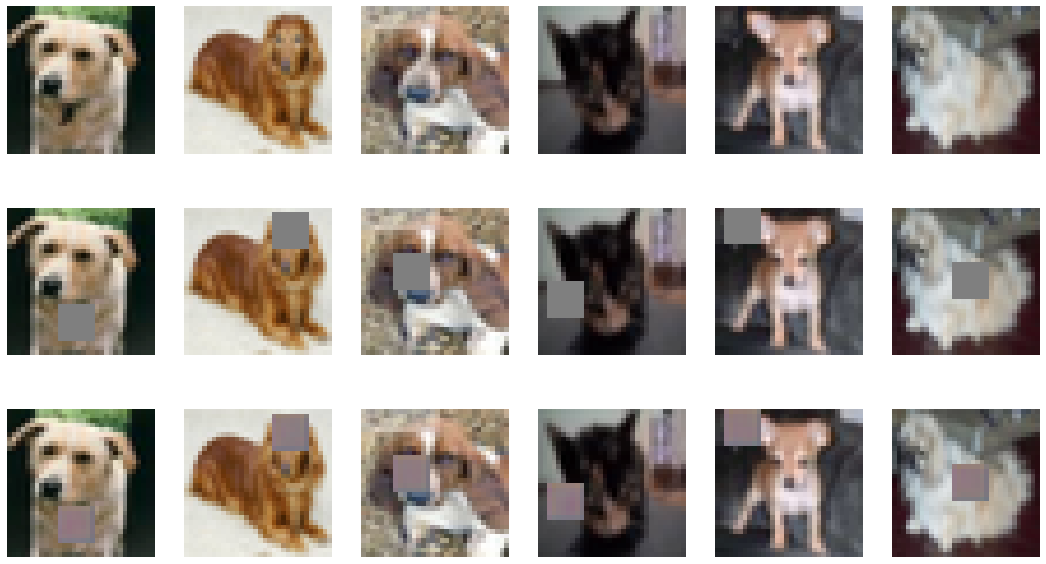

2/2 [==============================] - 0s 9ms/step
1 [D loss: 2.149145, acc: 46.09%] [G loss: 0.656432, mse: 0.656500]
2/2 [==============================] - 0s 9ms/step
2 [D loss: 0.164788, acc: 96.09%] [G loss: 0.627665, mse: 0.627777]
2/2 [==============================] - 0s 10ms/step
3 [D loss: 0.136378, acc: 96.88%] [G loss: 0.572101, mse: 0.572219]
2/2 [==============================] - 0s 9ms/step
4 [D loss: 0.110667, acc: 94.53%] [G loss: 0.595947, mse: 0.596113]
2/2 [==============================] - 0s 9ms/step
5 [D loss: 0.157642, acc: 98.44%] [G loss: 0.569566, mse: 0.569796]
2/2 [==============================] - 0s 10ms/step
6 [D loss: 0.098038, acc: 100.00%] [G loss: 0.572728, mse: 0.572948]
2/2 [==============================] - 0s 9ms/step
7 [D loss: 0.087052, acc: 99.22%] [G loss: 0.586727, mse: 0.586818]
2/2 [==============================] - 0s 11ms/step
8 [D loss: 0.073188, acc: 99.22%] [G loss: 0.521525, mse: 0.521609]
2/2 [==============================] - 0s 10

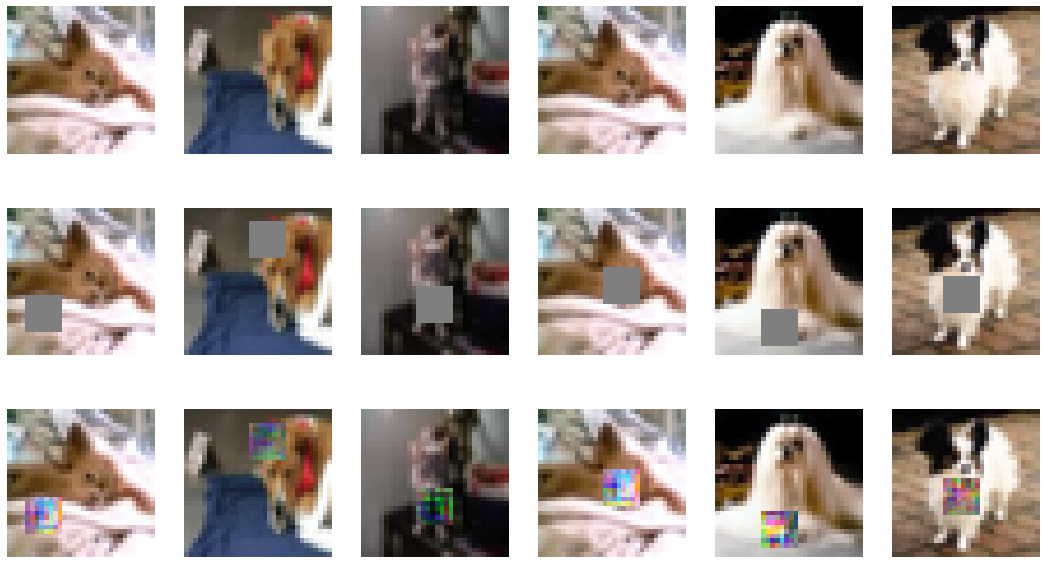

2/2 [==============================] - 0s 9ms/step
26 [D loss: 0.142818, acc: 96.09%] [G loss: 0.329133, mse: 0.327715]
2/2 [==============================] - 0s 9ms/step
27 [D loss: 0.155644, acc: 92.97%] [G loss: 0.275546, mse: 0.273892]
2/2 [==============================] - 0s 9ms/step
28 [D loss: 0.126365, acc: 97.66%] [G loss: 0.318471, mse: 0.316755]
2/2 [==============================] - 0s 9ms/step
29 [D loss: 0.110938, acc: 98.44%] [G loss: 0.225941, mse: 0.224163]
2/2 [==============================] - 0s 9ms/step
30 [D loss: 0.092953, acc: 98.44%] [G loss: 0.277658, mse: 0.275661]
2/2 [==============================] - 0s 9ms/step
31 [D loss: 0.092386, acc: 99.22%] [G loss: 0.229124, mse: 0.227421]
2/2 [==============================] - 0s 9ms/step
32 [D loss: 0.159832, acc: 95.31%] [G loss: 0.292147, mse: 0.290441]
2/2 [==============================] - 0s 10ms/step
33 [D loss: 0.061990, acc: 100.00%] [G loss: 0.316792, mse: 0.314904]
2/2 [==============================] -

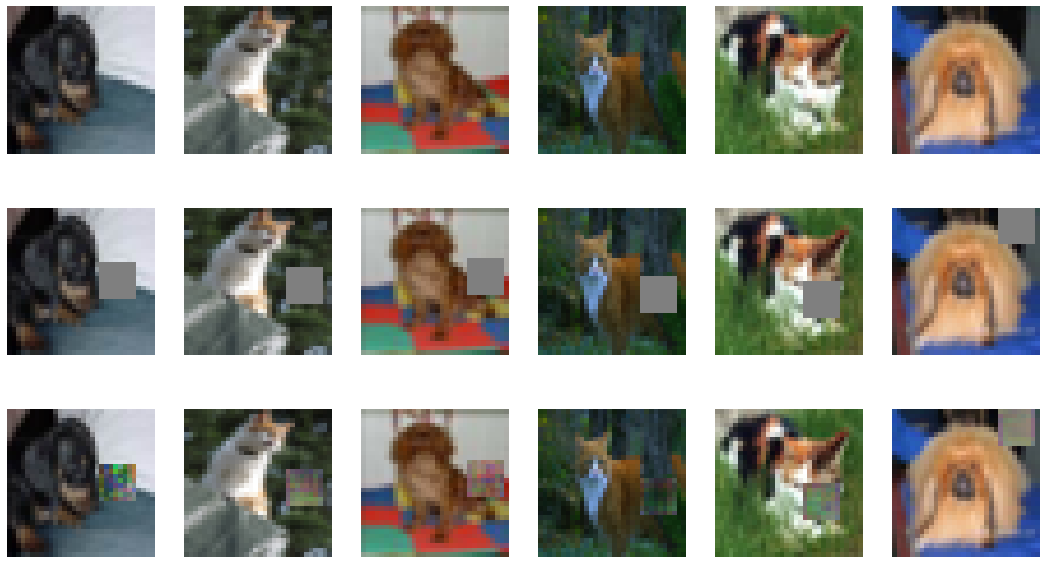

2/2 [==============================] - 0s 10ms/step
51 [D loss: 0.023340, acc: 100.00%] [G loss: 0.250616, mse: 0.248565]
2/2 [==============================] - 0s 9ms/step
52 [D loss: 0.030663, acc: 100.00%] [G loss: 0.248264, mse: 0.246096]
2/2 [==============================] - 0s 9ms/step
53 [D loss: 0.041813, acc: 99.22%] [G loss: 0.239687, mse: 0.237998]
2/2 [==============================] - 0s 11ms/step
54 [D loss: 0.035555, acc: 100.00%] [G loss: 0.263580, mse: 0.261947]
2/2 [==============================] - 0s 10ms/step
55 [D loss: 0.032192, acc: 100.00%] [G loss: 0.254774, mse: 0.253064]
2/2 [==============================] - 0s 10ms/step
56 [D loss: 0.028415, acc: 100.00%] [G loss: 0.226021, mse: 0.224120]
2/2 [==============================] - 0s 9ms/step
57 [D loss: 0.046067, acc: 100.00%] [G loss: 0.229950, mse: 0.227946]
2/2 [==============================] - 0s 10ms/step
58 [D loss: 0.022726, acc: 100.00%] [G loss: 0.242329, mse: 0.240193]
2/2 [=======================

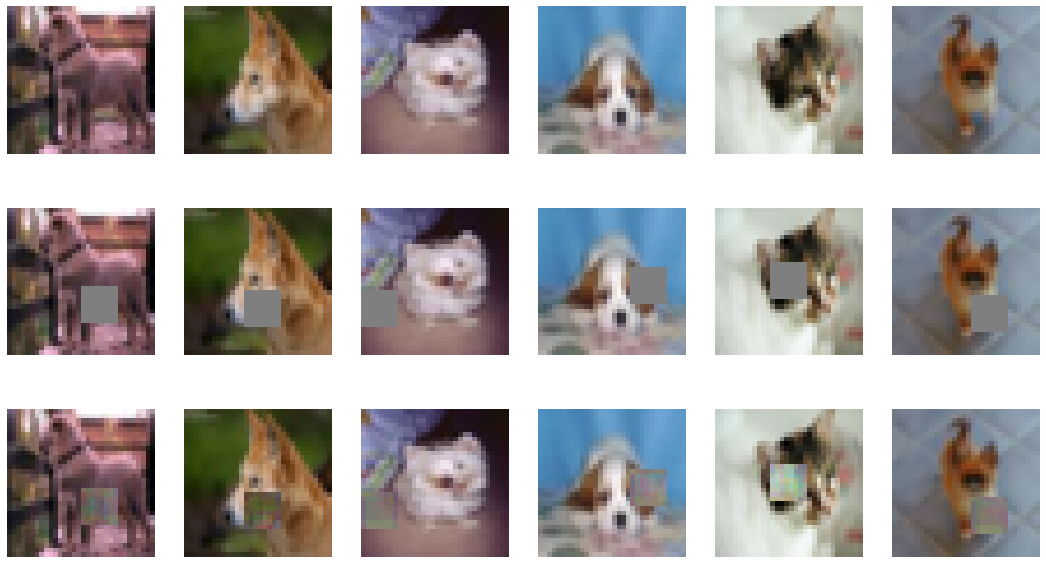

2/2 [==============================] - 0s 9ms/step
76 [D loss: 0.035391, acc: 100.00%] [G loss: 0.202221, mse: 0.200500]
2/2 [==============================] - 0s 8ms/step
77 [D loss: 0.031446, acc: 100.00%] [G loss: 0.235681, mse: 0.233996]
2/2 [==============================] - 0s 9ms/step
78 [D loss: 0.006424, acc: 100.00%] [G loss: 0.220808, mse: 0.219207]
2/2 [==============================] - 0s 10ms/step
79 [D loss: 0.011419, acc: 100.00%] [G loss: 0.233169, mse: 0.231468]
2/2 [==============================] - 0s 10ms/step
80 [D loss: 0.012183, acc: 100.00%] [G loss: 0.226558, mse: 0.224678]
2/2 [==============================] - 0s 11ms/step
81 [D loss: 0.024138, acc: 100.00%] [G loss: 0.233949, mse: 0.232415]
2/2 [==============================] - 0s 10ms/step
82 [D loss: 0.022874, acc: 100.00%] [G loss: 0.219369, mse: 0.217342]
2/2 [==============================] - 0s 11ms/step
83 [D loss: 0.012326, acc: 100.00%] [G loss: 0.193320, mse: 0.191926]
2/2 [======================

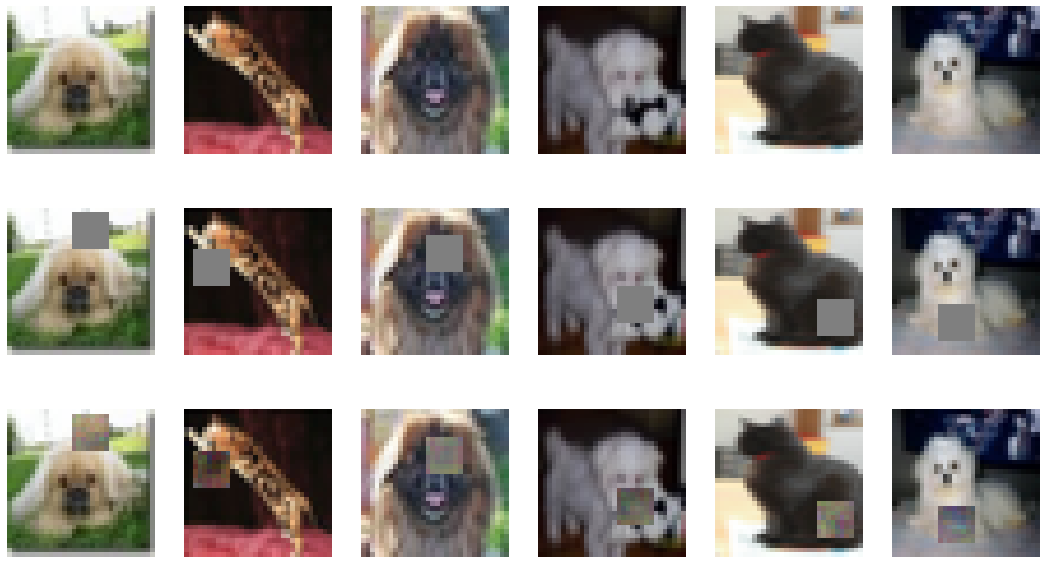

2/2 [==============================] - 0s 14ms/step
101 [D loss: 0.028682, acc: 100.00%] [G loss: 0.242951, mse: 0.241271]
2/2 [==============================] - 0s 10ms/step
102 [D loss: 0.024021, acc: 99.22%] [G loss: 0.228998, mse: 0.227485]
2/2 [==============================] - 0s 11ms/step
103 [D loss: 0.027706, acc: 100.00%] [G loss: 0.198835, mse: 0.197258]
2/2 [==============================] - 0s 11ms/step
104 [D loss: 0.026259, acc: 99.22%] [G loss: 0.256065, mse: 0.254464]
2/2 [==============================] - 0s 10ms/step
105 [D loss: 0.023860, acc: 100.00%] [G loss: 0.243521, mse: 0.242034]
2/2 [==============================] - 0s 11ms/step
106 [D loss: 0.015906, acc: 100.00%] [G loss: 0.217551, mse: 0.215692]
2/2 [==============================] - 0s 10ms/step
107 [D loss: 0.027785, acc: 99.22%] [G loss: 0.211947, mse: 0.210458]
2/2 [==============================] - 0s 12ms/step
108 [D loss: 0.018659, acc: 100.00%] [G loss: 0.221358, mse: 0.219919]
2/2 [==============

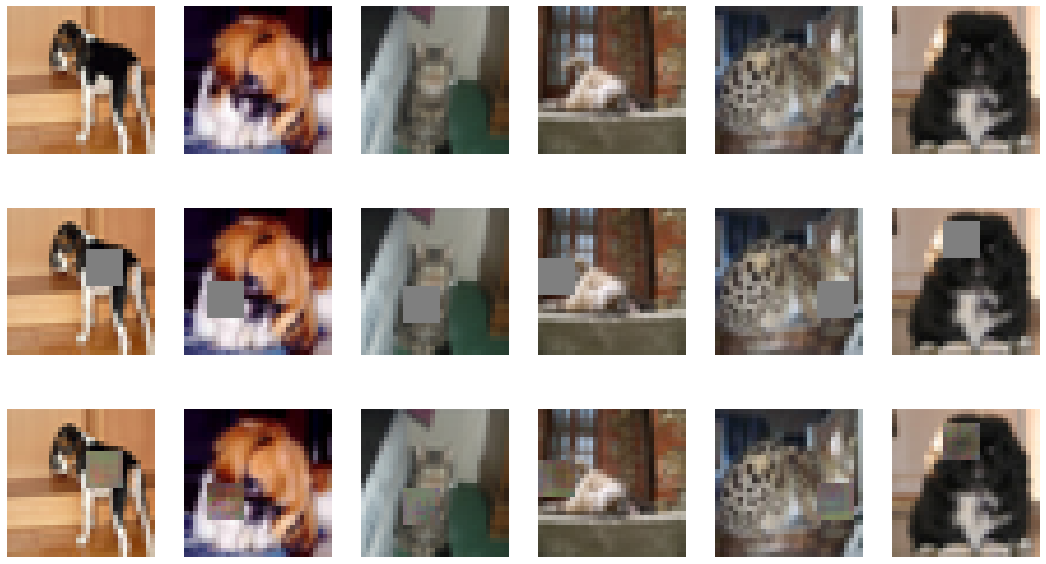

2/2 [==============================] - 0s 13ms/step
126 [D loss: 0.018188, acc: 100.00%] [G loss: 0.217537, mse: 0.216065]
2/2 [==============================] - 0s 11ms/step
127 [D loss: 0.006354, acc: 100.00%] [G loss: 0.215016, mse: 0.213645]
2/2 [==============================] - 0s 11ms/step
128 [D loss: 0.023557, acc: 99.22%] [G loss: 0.218271, mse: 0.216768]
2/2 [==============================] - 0s 10ms/step
129 [D loss: 0.032051, acc: 100.00%] [G loss: 0.219718, mse: 0.218342]
2/2 [==============================] - 0s 12ms/step
130 [D loss: 0.007811, acc: 100.00%] [G loss: 0.220375, mse: 0.218818]
2/2 [==============================] - 0s 11ms/step
131 [D loss: 0.012650, acc: 100.00%] [G loss: 0.230059, mse: 0.228714]
2/2 [==============================] - 0s 11ms/step
132 [D loss: 0.023305, acc: 100.00%] [G loss: 0.206785, mse: 0.205056]
2/2 [==============================] - 0s 9ms/step
133 [D loss: 0.042711, acc: 99.22%] [G loss: 0.236577, mse: 0.235524]
2/2 [==============

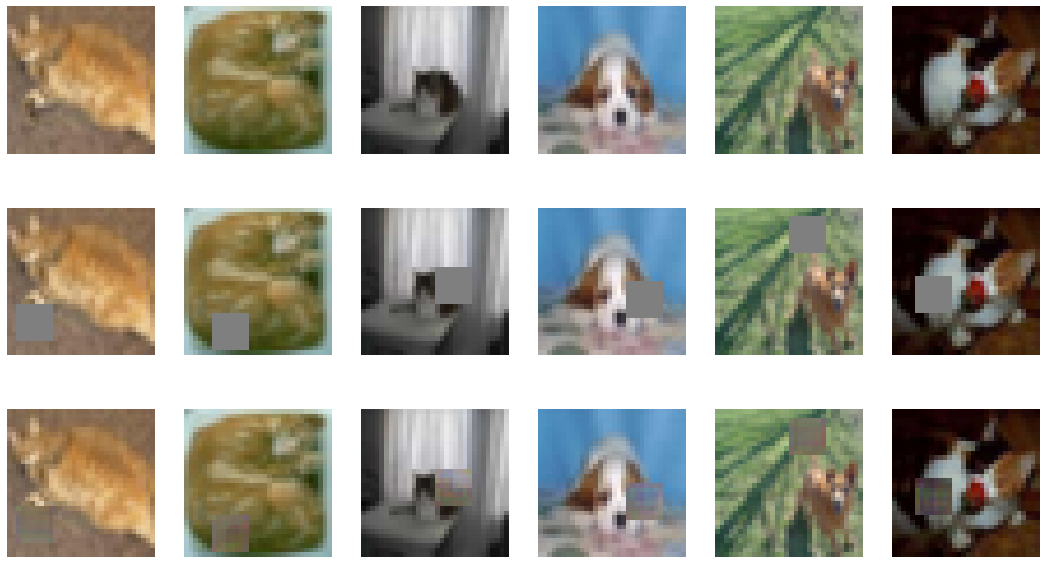

2/2 [==============================] - 0s 11ms/step
151 [D loss: 0.029368, acc: 100.00%] [G loss: 0.224151, mse: 0.222886]
2/2 [==============================] - 0s 10ms/step
152 [D loss: 0.007620, acc: 100.00%] [G loss: 0.228891, mse: 0.227533]
2/2 [==============================] - 0s 10ms/step
153 [D loss: 0.018476, acc: 100.00%] [G loss: 0.232131, mse: 0.231044]
2/2 [==============================] - 0s 11ms/step
154 [D loss: 0.005162, acc: 100.00%] [G loss: 0.222824, mse: 0.221444]
2/2 [==============================] - 0s 11ms/step
155 [D loss: 0.011146, acc: 100.00%] [G loss: 0.173976, mse: 0.172457]
2/2 [==============================] - 0s 9ms/step
156 [D loss: 0.008049, acc: 100.00%] [G loss: 0.225839, mse: 0.224455]
2/2 [==============================] - 0s 10ms/step
157 [D loss: 0.012981, acc: 100.00%] [G loss: 0.223688, mse: 0.222277]
2/2 [==============================] - 0s 10ms/step
158 [D loss: 0.012675, acc: 100.00%] [G loss: 0.205859, mse: 0.204638]
2/2 [============

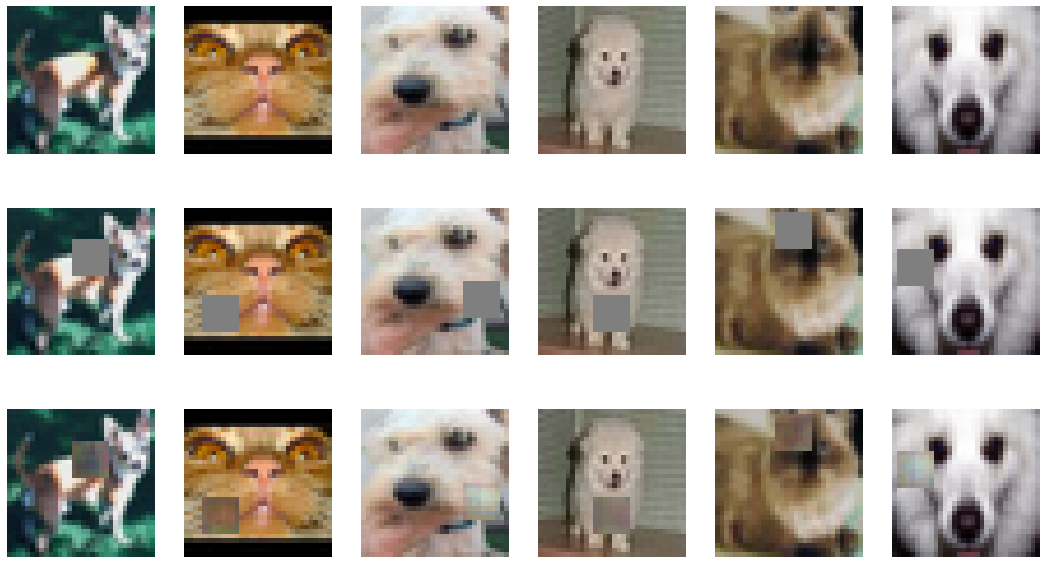

2/2 [==============================] - 0s 9ms/step
176 [D loss: 0.022254, acc: 100.00%] [G loss: 0.190570, mse: 0.189409]
2/2 [==============================] - 0s 11ms/step
177 [D loss: 0.009089, acc: 100.00%] [G loss: 0.245654, mse: 0.244642]
2/2 [==============================] - 0s 10ms/step
178 [D loss: 0.006688, acc: 100.00%] [G loss: 0.190556, mse: 0.189415]
2/2 [==============================] - 0s 9ms/step
179 [D loss: 0.002855, acc: 100.00%] [G loss: 0.206082, mse: 0.205064]
2/2 [==============================] - 0s 9ms/step
180 [D loss: 0.004508, acc: 100.00%] [G loss: 0.253612, mse: 0.252572]
2/2 [==============================] - 0s 10ms/step
181 [D loss: 0.003189, acc: 100.00%] [G loss: 0.269946, mse: 0.269124]
2/2 [==============================] - 0s 10ms/step
182 [D loss: 0.007214, acc: 100.00%] [G loss: 0.231721, mse: 0.230614]
2/2 [==============================] - 0s 9ms/step
183 [D loss: 0.004834, acc: 100.00%] [G loss: 0.188382, mse: 0.187285]
2/2 [===============

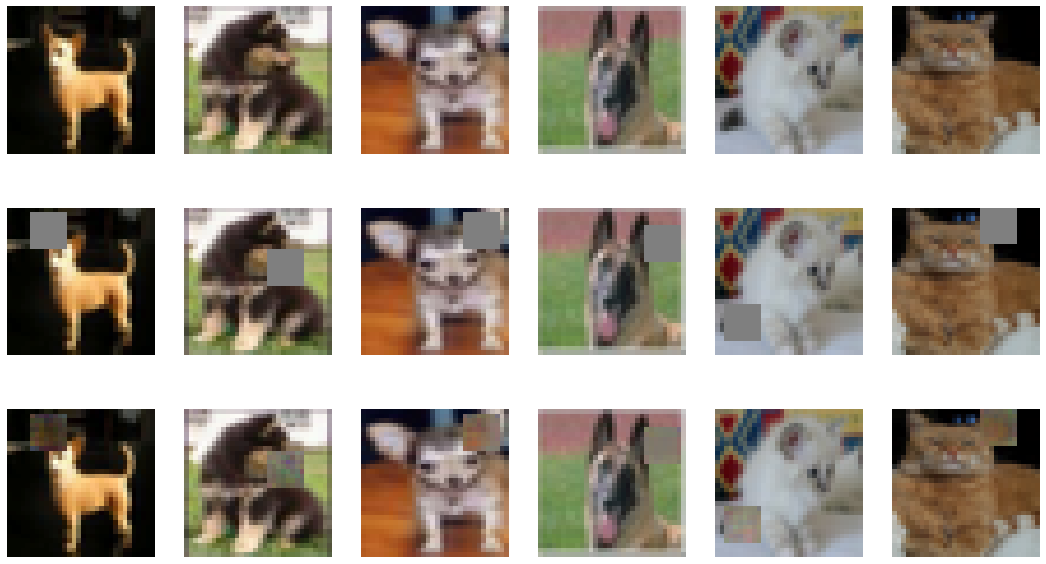

2/2 [==============================] - 0s 9ms/step
201 [D loss: 0.005132, acc: 100.00%] [G loss: 0.222294, mse: 0.221122]
2/2 [==============================] - 0s 10ms/step
202 [D loss: 0.019627, acc: 99.22%] [G loss: 0.195634, mse: 0.194547]
2/2 [==============================] - 0s 9ms/step
203 [D loss: 0.013155, acc: 100.00%] [G loss: 0.187564, mse: 0.186507]
2/2 [==============================] - 0s 9ms/step
204 [D loss: 0.024438, acc: 99.22%] [G loss: 0.173183, mse: 0.172052]
2/2 [==============================] - 0s 10ms/step
205 [D loss: 0.020179, acc: 100.00%] [G loss: 0.226847, mse: 0.225720]
2/2 [==============================] - 0s 10ms/step
206 [D loss: 0.008374, acc: 100.00%] [G loss: 0.214456, mse: 0.213183]
2/2 [==============================] - 0s 11ms/step
207 [D loss: 0.034518, acc: 100.00%] [G loss: 0.252298, mse: 0.250837]
2/2 [==============================] - 0s 10ms/step
208 [D loss: 0.016174, acc: 100.00%] [G loss: 0.193919, mse: 0.192343]
2/2 [================

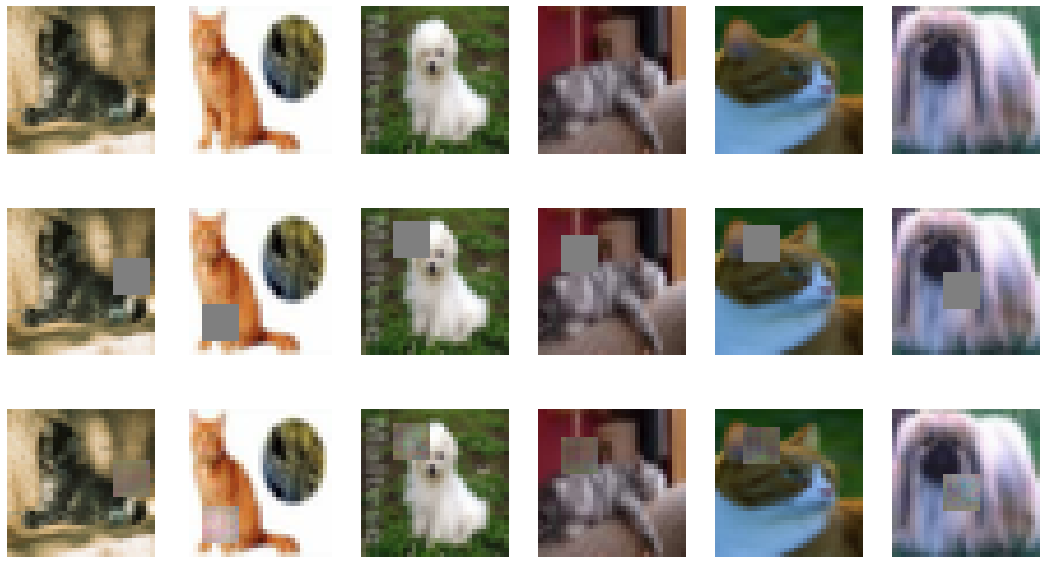

2/2 [==============================] - 0s 11ms/step
226 [D loss: 0.015418, acc: 100.00%] [G loss: 0.245174, mse: 0.243930]
2/2 [==============================] - 0s 11ms/step
227 [D loss: 0.007527, acc: 100.00%] [G loss: 0.217206, mse: 0.215813]
2/2 [==============================] - 0s 10ms/step
228 [D loss: 0.004287, acc: 100.00%] [G loss: 0.204305, mse: 0.202699]
2/2 [==============================] - 0s 9ms/step
229 [D loss: 0.004006, acc: 100.00%] [G loss: 0.222723, mse: 0.221289]
2/2 [==============================] - 0s 10ms/step
230 [D loss: 0.040048, acc: 100.00%] [G loss: 0.205909, mse: 0.204755]
2/2 [==============================] - 0s 11ms/step
231 [D loss: 0.004109, acc: 100.00%] [G loss: 0.213995, mse: 0.213175]
2/2 [==============================] - 0s 9ms/step
232 [D loss: 0.005591, acc: 100.00%] [G loss: 0.182996, mse: 0.181663]
2/2 [==============================] - 0s 11ms/step
233 [D loss: 0.002247, acc: 100.00%] [G loss: 0.208400, mse: 0.207274]
2/2 [=============

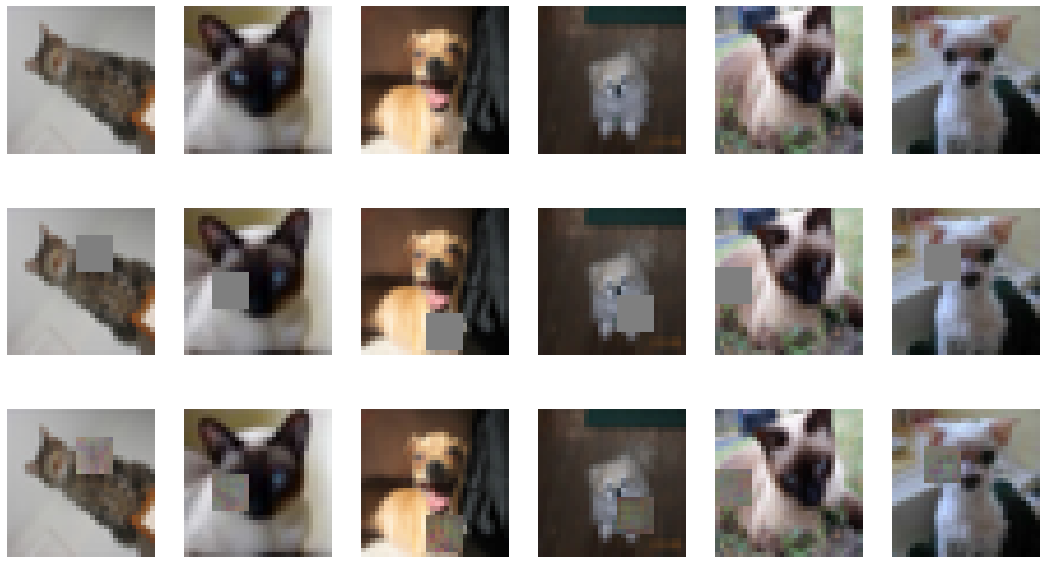

2/2 [==============================] - 0s 11ms/step
251 [D loss: 0.009567, acc: 100.00%] [G loss: 0.216326, mse: 0.215177]
2/2 [==============================] - 0s 9ms/step
252 [D loss: 0.001482, acc: 100.00%] [G loss: 0.205263, mse: 0.204048]
2/2 [==============================] - 0s 11ms/step
253 [D loss: 0.003148, acc: 100.00%] [G loss: 0.236774, mse: 0.235793]
2/2 [==============================] - 0s 12ms/step
254 [D loss: 0.003620, acc: 100.00%] [G loss: 0.205104, mse: 0.204258]
2/2 [==============================] - 0s 11ms/step
255 [D loss: 0.001133, acc: 100.00%] [G loss: 0.222927, mse: 0.222091]
2/2 [==============================] - 0s 10ms/step
256 [D loss: 0.005210, acc: 100.00%] [G loss: 0.208692, mse: 0.207602]
2/2 [==============================] - 0s 10ms/step
257 [D loss: 0.011455, acc: 100.00%] [G loss: 0.195430, mse: 0.194327]
2/2 [==============================] - 0s 10ms/step
258 [D loss: 0.010507, acc: 100.00%] [G loss: 0.221774, mse: 0.220900]
2/2 [============

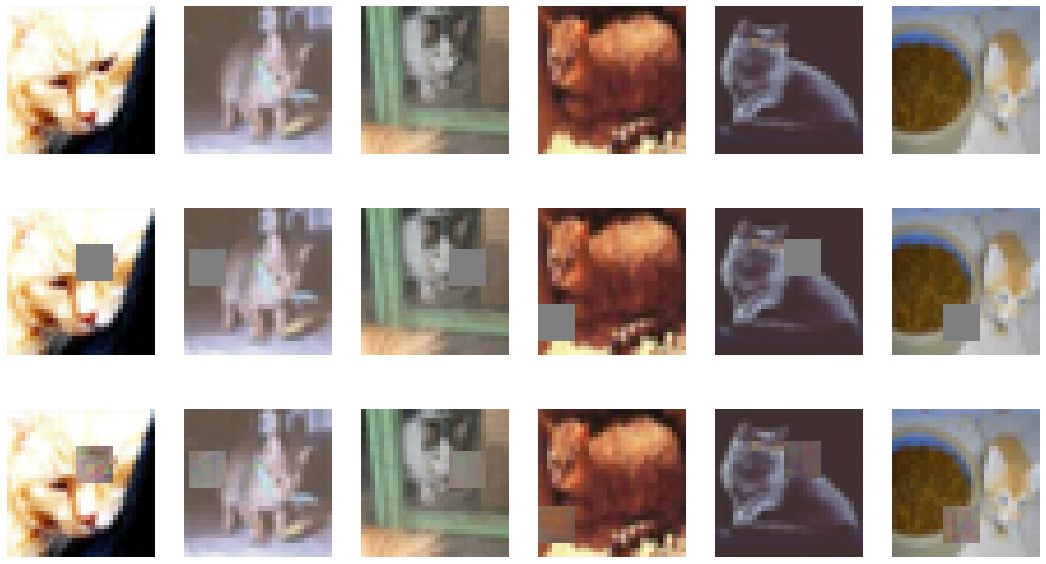

2/2 [==============================] - 0s 12ms/step
276 [D loss: 0.002003, acc: 100.00%] [G loss: 0.212528, mse: 0.210891]
2/2 [==============================] - 0s 11ms/step
277 [D loss: 0.004742, acc: 100.00%] [G loss: 0.223453, mse: 0.222239]
2/2 [==============================] - 0s 11ms/step
278 [D loss: 0.001607, acc: 100.00%] [G loss: 0.212610, mse: 0.211304]
2/2 [==============================] - 0s 10ms/step
279 [D loss: 0.007007, acc: 100.00%] [G loss: 0.184074, mse: 0.183137]
2/2 [==============================] - 0s 11ms/step
280 [D loss: 0.003769, acc: 100.00%] [G loss: 0.172957, mse: 0.171753]
2/2 [==============================] - 0s 11ms/step
281 [D loss: 0.002401, acc: 100.00%] [G loss: 0.203051, mse: 0.201959]
2/2 [==============================] - 0s 10ms/step
282 [D loss: 0.002232, acc: 100.00%] [G loss: 0.209940, mse: 0.208985]
2/2 [==============================] - 0s 10ms/step
283 [D loss: 0.005704, acc: 100.00%] [G loss: 0.200306, mse: 0.199163]
2/2 [===========

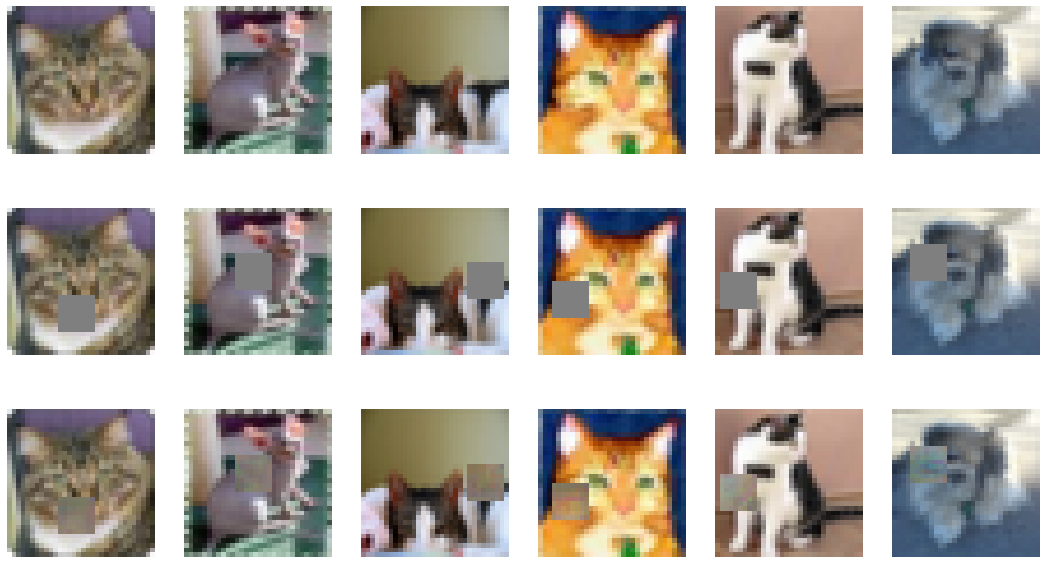

2/2 [==============================] - 0s 11ms/step
301 [D loss: 0.005471, acc: 100.00%] [G loss: 0.179799, mse: 0.178818]
2/2 [==============================] - 0s 11ms/step
302 [D loss: 0.000969, acc: 100.00%] [G loss: 0.214447, mse: 0.213595]
2/2 [==============================] - 0s 9ms/step
303 [D loss: 0.007022, acc: 100.00%] [G loss: 0.233713, mse: 0.232657]
2/2 [==============================] - 0s 10ms/step
304 [D loss: 0.002125, acc: 100.00%] [G loss: 0.249944, mse: 0.249388]
2/2 [==============================] - 0s 11ms/step
305 [D loss: 0.001337, acc: 100.00%] [G loss: 0.203474, mse: 0.202914]
2/2 [==============================] - 0s 10ms/step
306 [D loss: 0.000571, acc: 100.00%] [G loss: 0.210929, mse: 0.210557]
2/2 [==============================] - 0s 10ms/step
307 [D loss: 0.000915, acc: 100.00%] [G loss: 0.243768, mse: 0.243327]
2/2 [==============================] - 0s 11ms/step
308 [D loss: 0.002282, acc: 100.00%] [G loss: 0.214416, mse: 0.213759]
2/2 [============

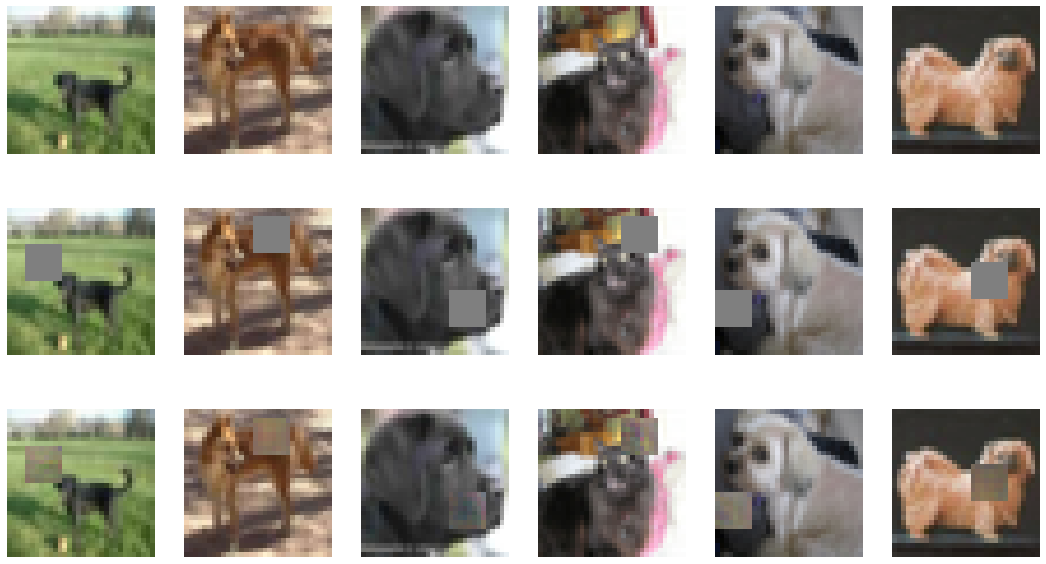

2/2 [==============================] - 0s 11ms/step
326 [D loss: 0.206230, acc: 91.41%] [G loss: 0.233946, mse: 0.232239]
2/2 [==============================] - 0s 14ms/step
327 [D loss: 0.029518, acc: 99.22%] [G loss: 0.193612, mse: 0.192329]
2/2 [==============================] - 0s 9ms/step
328 [D loss: 0.171060, acc: 94.53%] [G loss: 0.212718, mse: 0.211064]
2/2 [==============================] - 0s 10ms/step
329 [D loss: 0.301304, acc: 85.94%] [G loss: 0.213025, mse: 0.209533]
2/2 [==============================] - 0s 10ms/step
330 [D loss: 0.801831, acc: 86.72%] [G loss: 0.209079, mse: 0.207309]
2/2 [==============================] - 0s 10ms/step
331 [D loss: 0.922448, acc: 86.72%] [G loss: 0.208731, mse: 0.207108]
2/2 [==============================] - 0s 9ms/step
332 [D loss: 0.040859, acc: 98.44%] [G loss: 0.198997, mse: 0.196208]
2/2 [==============================] - 0s 9ms/step
333 [D loss: 0.609050, acc: 82.03%] [G loss: 0.205083, mse: 0.203349]
2/2 [======================

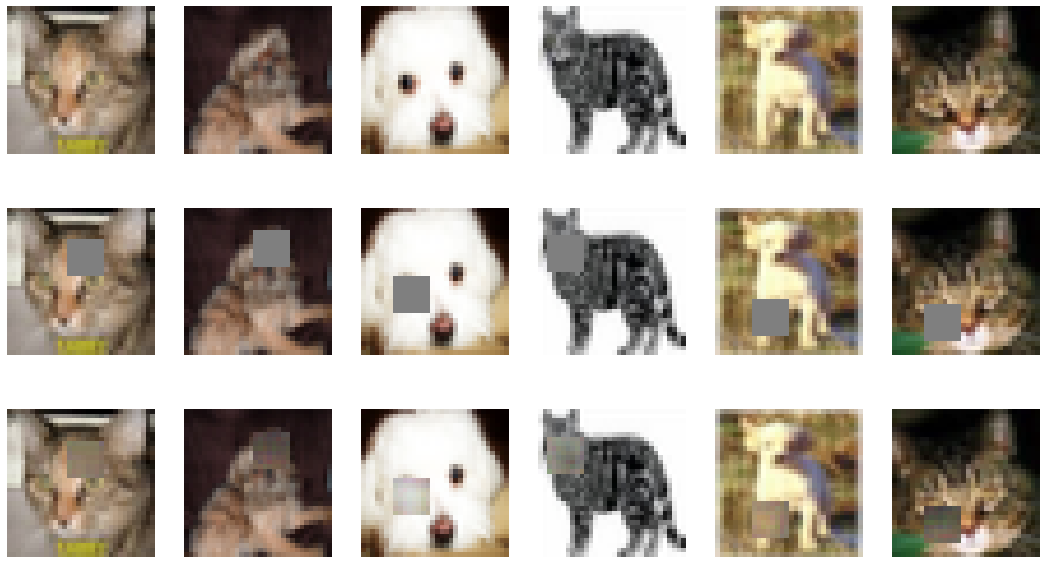

2/2 [==============================] - 0s 10ms/step
351 [D loss: 0.001129, acc: 100.00%] [G loss: 0.204780, mse: 0.203689]
2/2 [==============================] - 0s 11ms/step
352 [D loss: 0.029835, acc: 100.00%] [G loss: 0.177076, mse: 0.175768]
2/2 [==============================] - 0s 11ms/step
353 [D loss: 0.000717, acc: 100.00%] [G loss: 0.220152, mse: 0.218608]
2/2 [==============================] - 0s 9ms/step
354 [D loss: 0.015868, acc: 100.00%] [G loss: 0.192832, mse: 0.191952]
2/2 [==============================] - 0s 10ms/step
355 [D loss: 0.004769, acc: 100.00%] [G loss: 0.203817, mse: 0.203012]
2/2 [==============================] - 0s 10ms/step
356 [D loss: 0.002819, acc: 100.00%] [G loss: 0.195132, mse: 0.194060]
2/2 [==============================] - 0s 10ms/step
357 [D loss: 0.027403, acc: 100.00%] [G loss: 0.222566, mse: 0.221767]
2/2 [==============================] - 0s 10ms/step
358 [D loss: 0.003720, acc: 100.00%] [G loss: 0.190691, mse: 0.189695]
2/2 [============

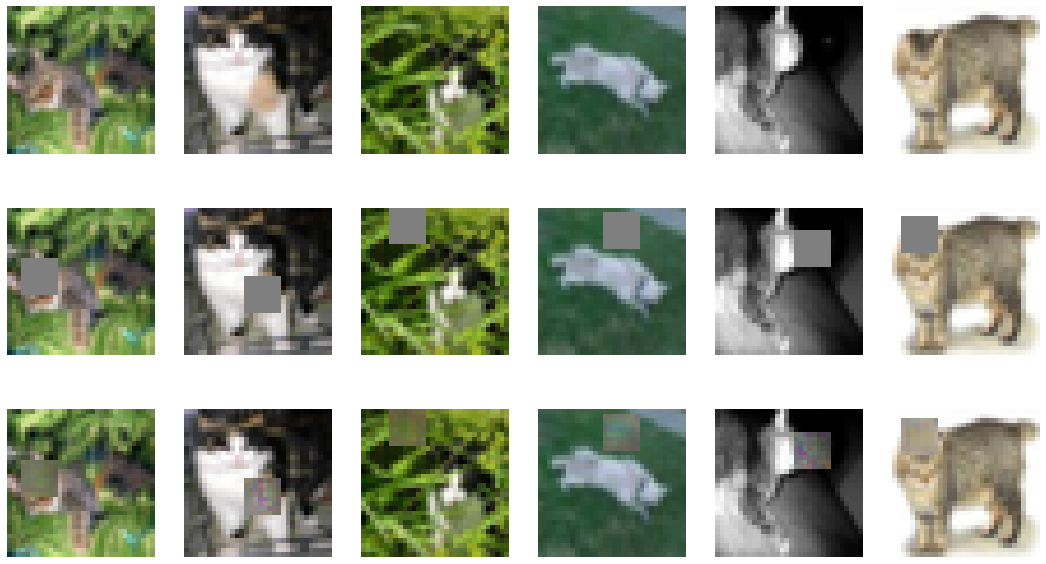

2/2 [==============================] - 0s 10ms/step
376 [D loss: 0.002598, acc: 100.00%] [G loss: 0.182218, mse: 0.180850]
2/2 [==============================] - 0s 9ms/step
377 [D loss: 0.006681, acc: 100.00%] [G loss: 0.253907, mse: 0.252995]
2/2 [==============================] - 0s 9ms/step
378 [D loss: 0.000865, acc: 100.00%] [G loss: 0.191088, mse: 0.189228]
2/2 [==============================] - 0s 10ms/step
379 [D loss: 0.010571, acc: 100.00%] [G loss: 0.234035, mse: 0.232910]
2/2 [==============================] - 0s 10ms/step
380 [D loss: 0.001550, acc: 100.00%] [G loss: 0.206573, mse: 0.205209]
2/2 [==============================] - 0s 9ms/step
381 [D loss: 0.003800, acc: 100.00%] [G loss: 0.202043, mse: 0.200207]
2/2 [==============================] - 0s 12ms/step
382 [D loss: 0.001620, acc: 100.00%] [G loss: 0.210977, mse: 0.208961]
2/2 [==============================] - 0s 10ms/step
383 [D loss: 0.001196, acc: 100.00%] [G loss: 0.205424, mse: 0.203795]
2/2 [==============

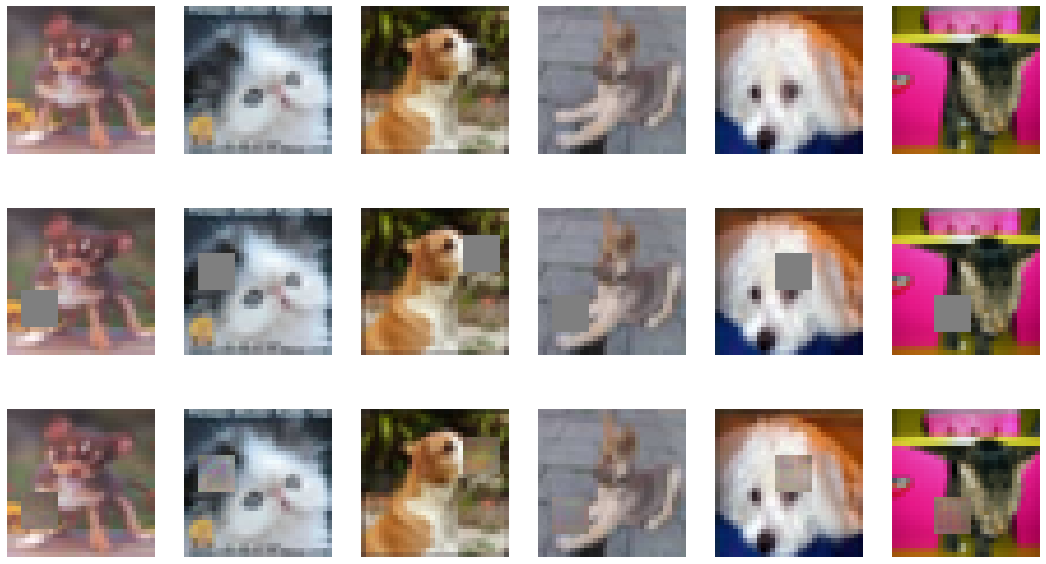

2/2 [==============================] - 0s 10ms/step
401 [D loss: 0.004953, acc: 100.00%] [G loss: 0.208697, mse: 0.207681]
2/2 [==============================] - 0s 11ms/step
402 [D loss: 0.001619, acc: 100.00%] [G loss: 0.204029, mse: 0.202951]
2/2 [==============================] - 0s 9ms/step
403 [D loss: 0.000900, acc: 100.00%] [G loss: 0.231099, mse: 0.230184]
2/2 [==============================] - 0s 9ms/step
404 [D loss: 0.001212, acc: 100.00%] [G loss: 0.171794, mse: 0.170531]
2/2 [==============================] - 0s 10ms/step
405 [D loss: 0.001332, acc: 100.00%] [G loss: 0.228251, mse: 0.226741]
2/2 [==============================] - 0s 9ms/step
406 [D loss: 0.001076, acc: 100.00%] [G loss: 0.211333, mse: 0.209778]
2/2 [==============================] - 0s 10ms/step
407 [D loss: 0.000787, acc: 100.00%] [G loss: 0.208058, mse: 0.206808]
2/2 [==============================] - 0s 8ms/step
408 [D loss: 0.001786, acc: 100.00%] [G loss: 0.230296, mse: 0.229274]
2/2 [===============

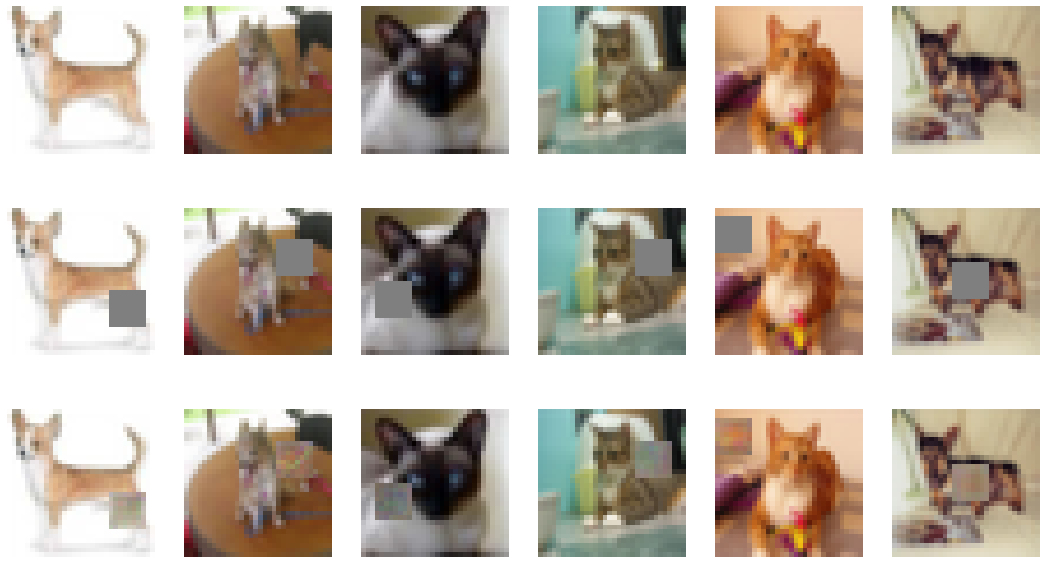

2/2 [==============================] - 0s 10ms/step
426 [D loss: 0.000400, acc: 100.00%] [G loss: 0.233039, mse: 0.232063]
2/2 [==============================] - 0s 9ms/step
427 [D loss: 0.001106, acc: 100.00%] [G loss: 0.217476, mse: 0.216433]
2/2 [==============================] - 0s 10ms/step
428 [D loss: 0.001199, acc: 100.00%] [G loss: 0.196177, mse: 0.194726]
2/2 [==============================] - 0s 10ms/step
429 [D loss: 0.001198, acc: 100.00%] [G loss: 0.180340, mse: 0.179253]
2/2 [==============================] - 0s 9ms/step
430 [D loss: 0.000812, acc: 100.00%] [G loss: 0.201937, mse: 0.200968]
2/2 [==============================] - 0s 10ms/step
431 [D loss: 0.001357, acc: 100.00%] [G loss: 0.235492, mse: 0.234714]
2/2 [==============================] - 0s 18ms/step
432 [D loss: 0.000888, acc: 100.00%] [G loss: 0.192306, mse: 0.191341]
2/2 [==============================] - 0s 9ms/step
433 [D loss: 0.000498, acc: 100.00%] [G loss: 0.257673, mse: 0.256720]
2/2 [==============

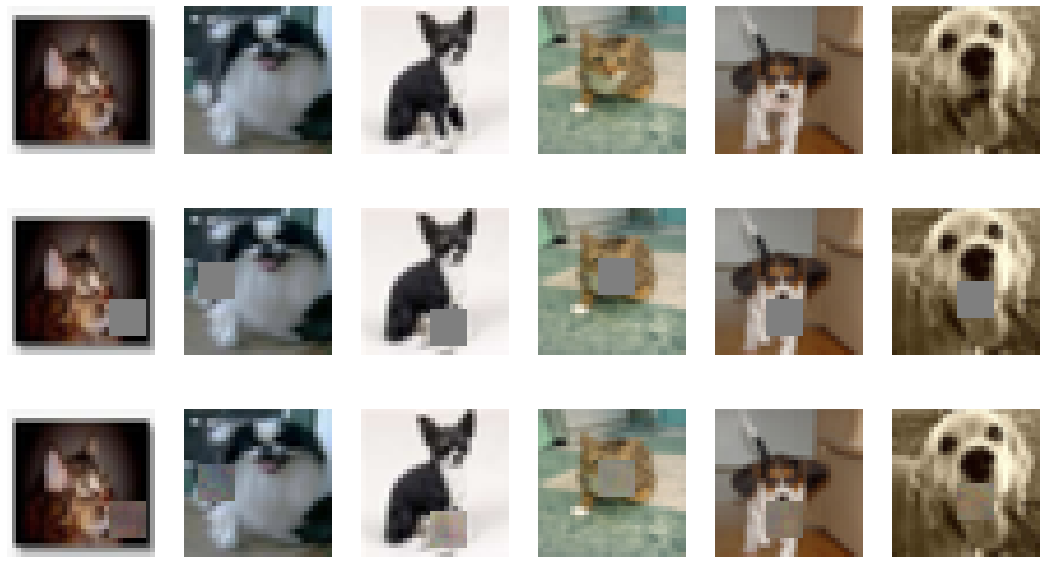

2/2 [==============================] - 0s 10ms/step
451 [D loss: 0.001030, acc: 100.00%] [G loss: 0.189337, mse: 0.188035]
2/2 [==============================] - 0s 9ms/step
452 [D loss: 0.000650, acc: 100.00%] [G loss: 0.200988, mse: 0.199721]
2/2 [==============================] - 0s 9ms/step
453 [D loss: 0.004194, acc: 100.00%] [G loss: 0.209635, mse: 0.208337]
2/2 [==============================] - 0s 9ms/step
454 [D loss: 0.003957, acc: 100.00%] [G loss: 0.227660, mse: 0.226757]
2/2 [==============================] - 0s 10ms/step
455 [D loss: 0.000717, acc: 100.00%] [G loss: 0.198502, mse: 0.197728]
2/2 [==============================] - 0s 10ms/step
456 [D loss: 0.002211, acc: 100.00%] [G loss: 0.203931, mse: 0.203357]
2/2 [==============================] - 0s 10ms/step
457 [D loss: 0.013945, acc: 100.00%] [G loss: 0.217506, mse: 0.216905]
2/2 [==============================] - 0s 10ms/step
458 [D loss: 0.000552, acc: 100.00%] [G loss: 0.180172, mse: 0.179286]
2/2 [==============

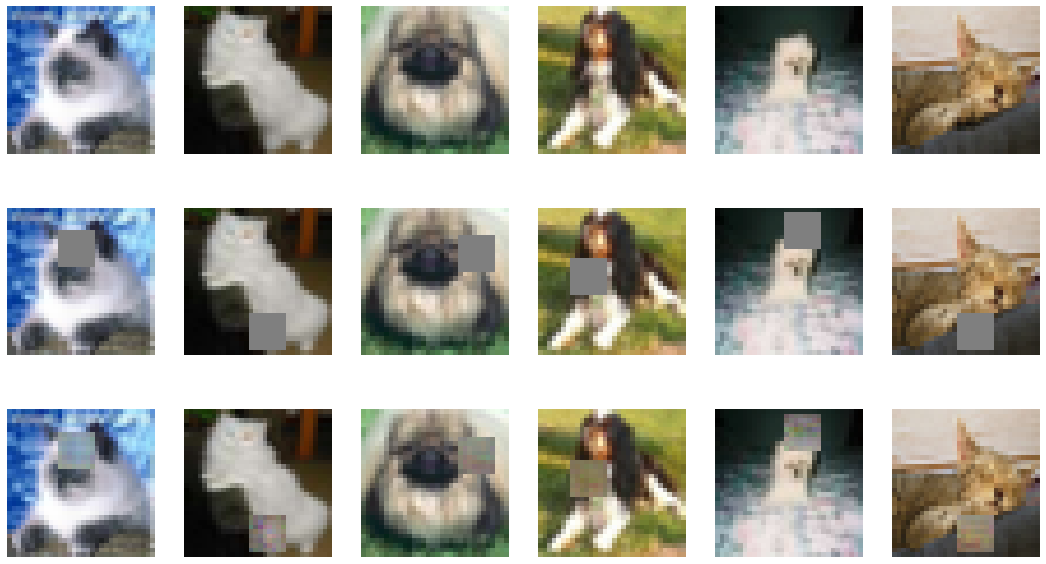

2/2 [==============================] - 0s 9ms/step
476 [D loss: 0.002983, acc: 100.00%] [G loss: 0.162252, mse: 0.160237]
2/2 [==============================] - 0s 13ms/step
477 [D loss: 0.004425, acc: 100.00%] [G loss: 0.211934, mse: 0.210686]
2/2 [==============================] - 0s 10ms/step
478 [D loss: 0.000301, acc: 100.00%] [G loss: 0.205291, mse: 0.204167]
2/2 [==============================] - 0s 10ms/step
479 [D loss: 0.000299, acc: 100.00%] [G loss: 0.202038, mse: 0.200982]
2/2 [==============================] - 0s 14ms/step
480 [D loss: 0.000577, acc: 100.00%] [G loss: 0.204460, mse: 0.203333]
2/2 [==============================] - 0s 10ms/step
481 [D loss: 0.001796, acc: 100.00%] [G loss: 0.167946, mse: 0.166569]
2/2 [==============================] - 0s 10ms/step
482 [D loss: 0.000819, acc: 100.00%] [G loss: 0.230362, mse: 0.228702]
2/2 [==============================] - 0s 11ms/step
483 [D loss: 0.002360, acc: 100.00%] [G loss: 0.197202, mse: 0.195981]
2/2 [============

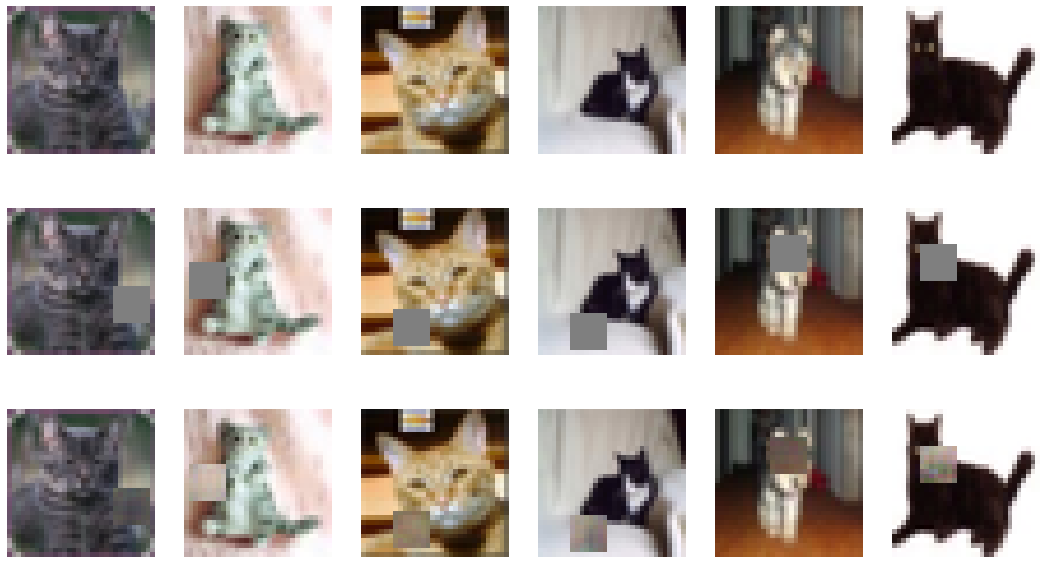

2/2 [==============================] - 0s 10ms/step
501 [D loss: 0.000868, acc: 100.00%] [G loss: 0.240279, mse: 0.239579]
2/2 [==============================] - 0s 11ms/step
502 [D loss: 0.000715, acc: 100.00%] [G loss: 0.215033, mse: 0.214163]
2/2 [==============================] - 0s 9ms/step
503 [D loss: 0.000531, acc: 100.00%] [G loss: 0.174932, mse: 0.173854]
2/2 [==============================] - 0s 11ms/step
504 [D loss: 0.001372, acc: 100.00%] [G loss: 0.192624, mse: 0.191216]
2/2 [==============================] - 0s 9ms/step
505 [D loss: 0.000374, acc: 100.00%] [G loss: 0.192845, mse: 0.191320]
2/2 [==============================] - 0s 11ms/step
506 [D loss: 0.000529, acc: 100.00%] [G loss: 0.183579, mse: 0.182282]
2/2 [==============================] - 0s 14ms/step
507 [D loss: 0.001076, acc: 100.00%] [G loss: 0.210532, mse: 0.209721]
2/2 [==============================] - 0s 10ms/step
508 [D loss: 0.003790, acc: 100.00%] [G loss: 0.181701, mse: 0.180748]
2/2 [=============

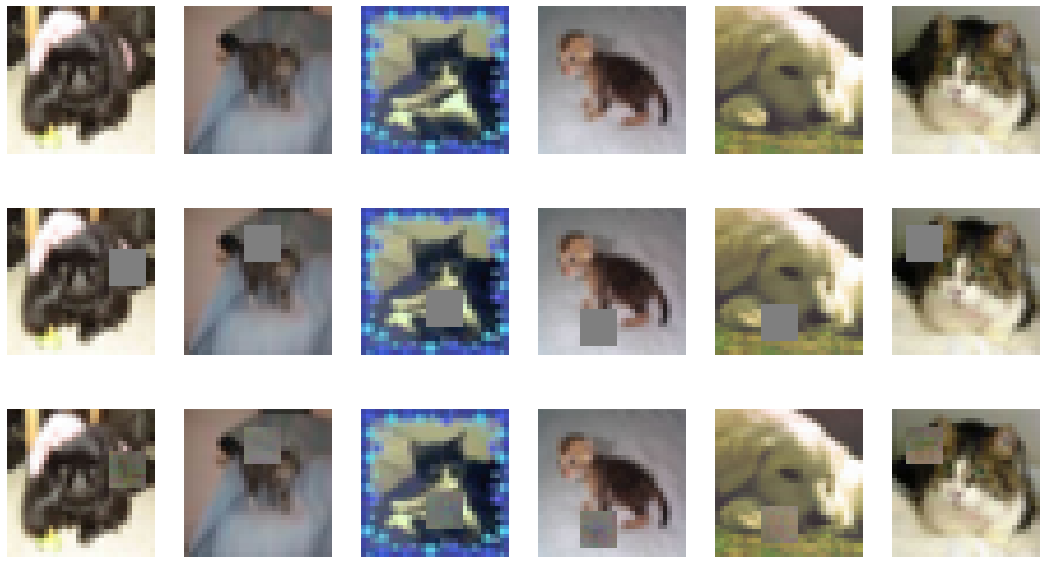

2/2 [==============================] - 0s 10ms/step
526 [D loss: 0.000546, acc: 100.00%] [G loss: 0.188334, mse: 0.187140]
2/2 [==============================] - 0s 9ms/step
527 [D loss: 0.000833, acc: 100.00%] [G loss: 0.193672, mse: 0.192813]
2/2 [==============================] - 0s 9ms/step
528 [D loss: 0.000253, acc: 100.00%] [G loss: 0.198595, mse: 0.197418]
2/2 [==============================] - 0s 10ms/step
529 [D loss: 0.000546, acc: 100.00%] [G loss: 0.198266, mse: 0.197367]
2/2 [==============================] - 0s 10ms/step
530 [D loss: 0.000339, acc: 100.00%] [G loss: 0.210381, mse: 0.209551]
2/2 [==============================] - 0s 10ms/step
531 [D loss: 0.003617, acc: 100.00%] [G loss: 0.196926, mse: 0.195800]
2/2 [==============================] - 0s 16ms/step
532 [D loss: 0.009031, acc: 100.00%] [G loss: 0.218274, mse: 0.217725]
2/2 [==============================] - 0s 10ms/step
533 [D loss: 0.001296, acc: 100.00%] [G loss: 0.227763, mse: 0.227163]
2/2 [=============

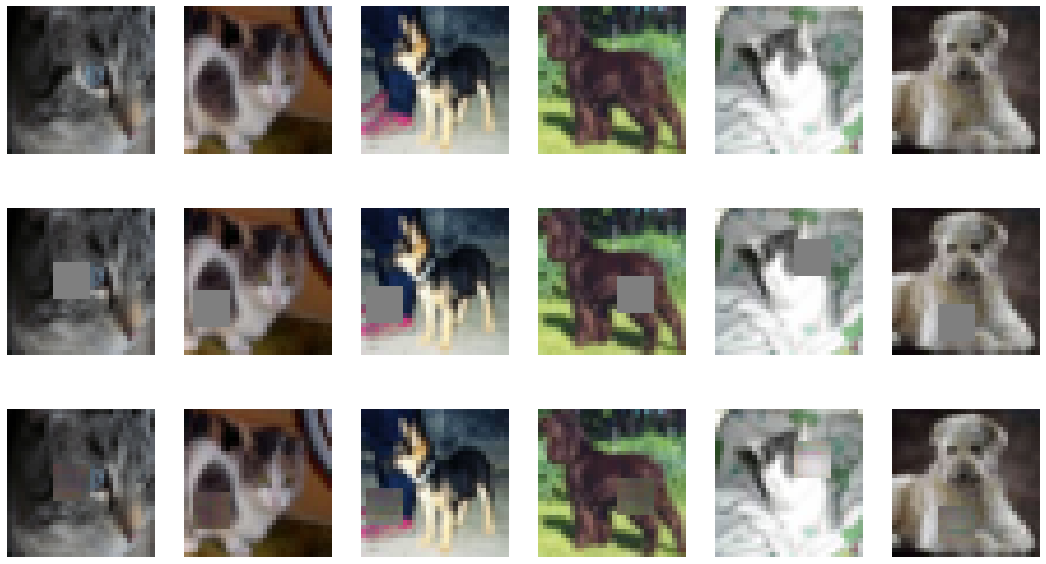

2/2 [==============================] - 0s 10ms/step
551 [D loss: 0.001652, acc: 100.00%] [G loss: 0.186427, mse: 0.185345]
2/2 [==============================] - 0s 10ms/step
552 [D loss: 0.000246, acc: 100.00%] [G loss: 0.196075, mse: 0.194738]
2/2 [==============================] - 0s 10ms/step
553 [D loss: 0.000344, acc: 100.00%] [G loss: 0.213263, mse: 0.212088]
2/2 [==============================] - 0s 10ms/step
554 [D loss: 0.002438, acc: 100.00%] [G loss: 0.192813, mse: 0.191978]
2/2 [==============================] - 0s 11ms/step
555 [D loss: 0.000722, acc: 100.00%] [G loss: 0.213610, mse: 0.212518]
2/2 [==============================] - 0s 10ms/step
556 [D loss: 0.001066, acc: 100.00%] [G loss: 0.205859, mse: 0.204320]
2/2 [==============================] - 0s 10ms/step
557 [D loss: 0.000741, acc: 100.00%] [G loss: 0.203617, mse: 0.202446]
2/2 [==============================] - 0s 10ms/step
558 [D loss: 0.001651, acc: 100.00%] [G loss: 0.204860, mse: 0.203224]
2/2 [===========

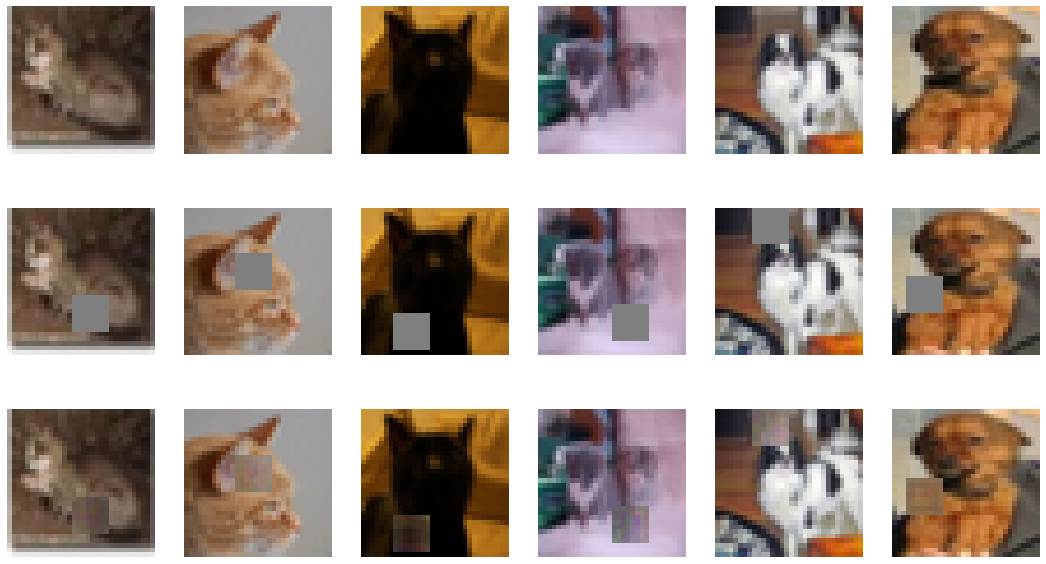

2/2 [==============================] - 0s 11ms/step
576 [D loss: 0.001789, acc: 100.00%] [G loss: 0.219555, mse: 0.218486]
2/2 [==============================] - 0s 10ms/step
577 [D loss: 0.001220, acc: 100.00%] [G loss: 0.196414, mse: 0.195175]
2/2 [==============================] - 0s 11ms/step
578 [D loss: 0.015862, acc: 100.00%] [G loss: 0.180653, mse: 0.179682]
2/2 [==============================] - 0s 9ms/step
579 [D loss: 0.001875, acc: 100.00%] [G loss: 0.190651, mse: 0.189356]
2/2 [==============================] - 0s 9ms/step
580 [D loss: 0.001009, acc: 100.00%] [G loss: 0.196487, mse: 0.195458]
2/2 [==============================] - 0s 9ms/step
581 [D loss: 0.001379, acc: 100.00%] [G loss: 0.177331, mse: 0.176126]
2/2 [==============================] - 0s 10ms/step
582 [D loss: 0.000958, acc: 100.00%] [G loss: 0.225450, mse: 0.224410]
2/2 [==============================] - 0s 11ms/step
583 [D loss: 0.002455, acc: 100.00%] [G loss: 0.203192, mse: 0.201560]
2/2 [==============

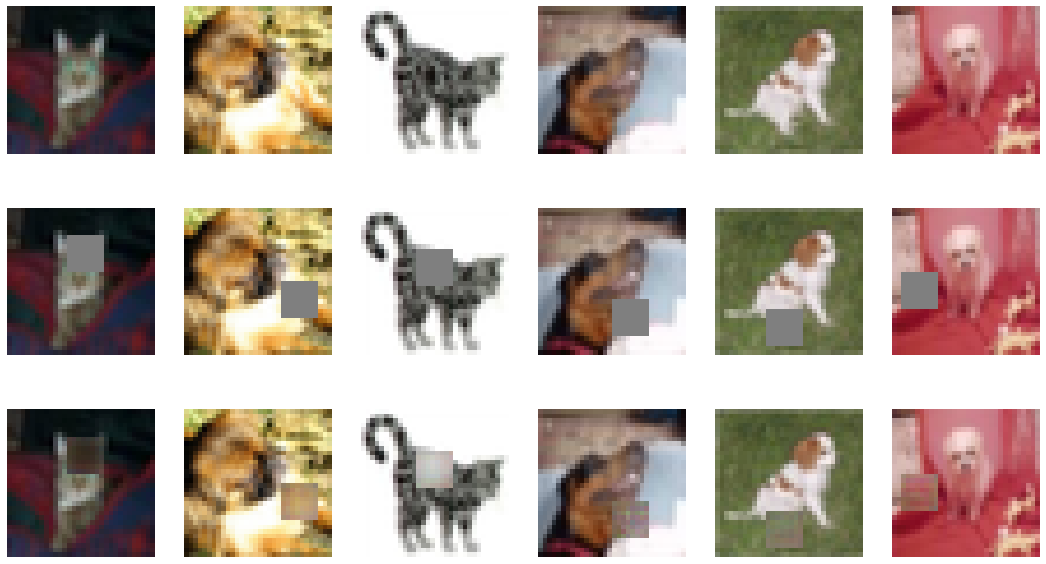

2/2 [==============================] - 0s 12ms/step
601 [D loss: 0.001069, acc: 100.00%] [G loss: 0.205685, mse: 0.204320]
2/2 [==============================] - 0s 11ms/step
602 [D loss: 0.000188, acc: 100.00%] [G loss: 0.176176, mse: 0.174965]
2/2 [==============================] - 0s 11ms/step
603 [D loss: 0.000748, acc: 100.00%] [G loss: 0.186429, mse: 0.185060]
2/2 [==============================] - 0s 11ms/step
604 [D loss: 0.000454, acc: 100.00%] [G loss: 0.224899, mse: 0.223474]
2/2 [==============================] - 0s 11ms/step
605 [D loss: 0.001575, acc: 100.00%] [G loss: 0.180354, mse: 0.178843]
2/2 [==============================] - 0s 11ms/step
606 [D loss: 0.000283, acc: 100.00%] [G loss: 0.190113, mse: 0.188899]
2/2 [==============================] - 0s 11ms/step
607 [D loss: 0.000386, acc: 100.00%] [G loss: 0.227028, mse: 0.225798]
2/2 [==============================] - 0s 13ms/step
608 [D loss: 0.000260, acc: 100.00%] [G loss: 0.222008, mse: 0.220759]
2/2 [===========

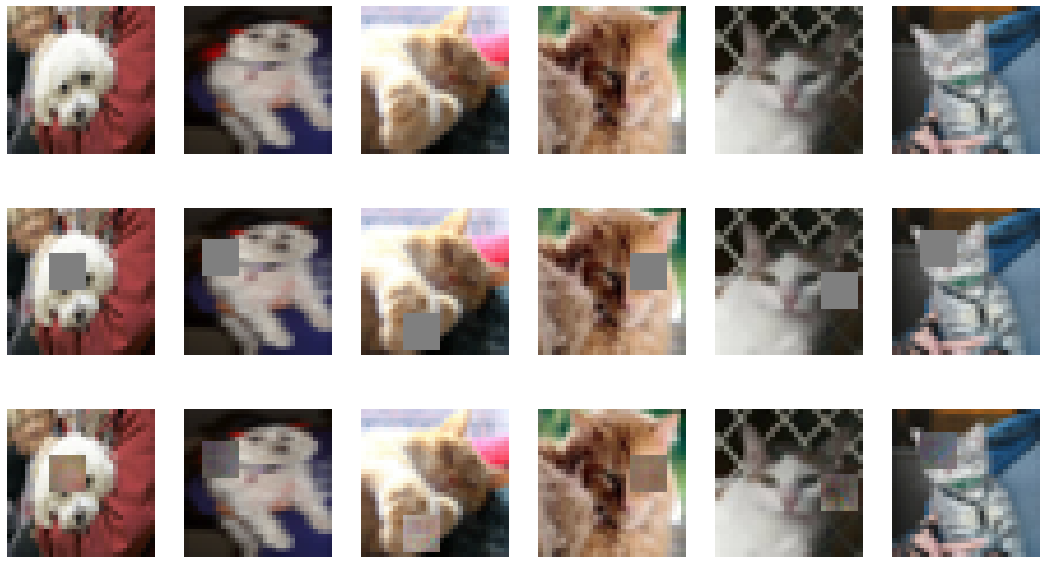

2/2 [==============================] - 0s 12ms/step
626 [D loss: 0.000112, acc: 100.00%] [G loss: 0.211306, mse: 0.209931]
2/2 [==============================] - 0s 11ms/step
627 [D loss: 0.000373, acc: 100.00%] [G loss: 0.229949, mse: 0.228534]
2/2 [==============================] - 0s 11ms/step
628 [D loss: 0.000135, acc: 100.00%] [G loss: 0.235531, mse: 0.234231]
2/2 [==============================] - 0s 11ms/step
629 [D loss: 0.000236, acc: 100.00%] [G loss: 0.221262, mse: 0.219496]
2/2 [==============================] - 0s 11ms/step
630 [D loss: 0.001057, acc: 100.00%] [G loss: 0.195375, mse: 0.194512]
2/2 [==============================] - 0s 11ms/step
631 [D loss: 0.000676, acc: 100.00%] [G loss: 0.223162, mse: 0.222373]
2/2 [==============================] - 0s 10ms/step
632 [D loss: 0.000056, acc: 100.00%] [G loss: 0.175842, mse: 0.175040]
2/2 [==============================] - 0s 10ms/step
633 [D loss: 0.000154, acc: 100.00%] [G loss: 0.171408, mse: 0.170320]
2/2 [===========

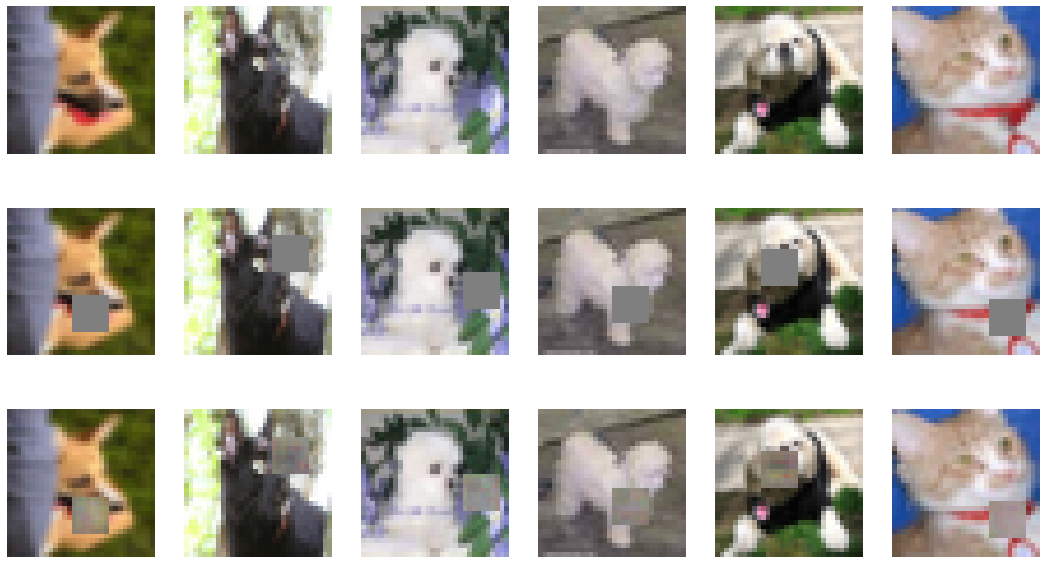

2/2 [==============================] - 0s 14ms/step
651 [D loss: 0.000133, acc: 100.00%] [G loss: 0.199902, mse: 0.199094]
2/2 [==============================] - 0s 11ms/step
652 [D loss: 0.000075, acc: 100.00%] [G loss: 0.213630, mse: 0.212898]
2/2 [==============================] - 0s 12ms/step
653 [D loss: 0.000822, acc: 100.00%] [G loss: 0.199391, mse: 0.198562]
2/2 [==============================] - 0s 14ms/step
654 [D loss: 0.000266, acc: 100.00%] [G loss: 0.199370, mse: 0.198484]
2/2 [==============================] - 0s 10ms/step
655 [D loss: 0.000329, acc: 100.00%] [G loss: 0.222159, mse: 0.221572]
2/2 [==============================] - 0s 11ms/step
656 [D loss: 0.000257, acc: 100.00%] [G loss: 0.175082, mse: 0.174135]
2/2 [==============================] - 0s 11ms/step
657 [D loss: 0.014621, acc: 100.00%] [G loss: 0.207413, mse: 0.207067]
2/2 [==============================] - 0s 11ms/step
658 [D loss: 0.000516, acc: 100.00%] [G loss: 0.191926, mse: 0.191250]
2/2 [===========

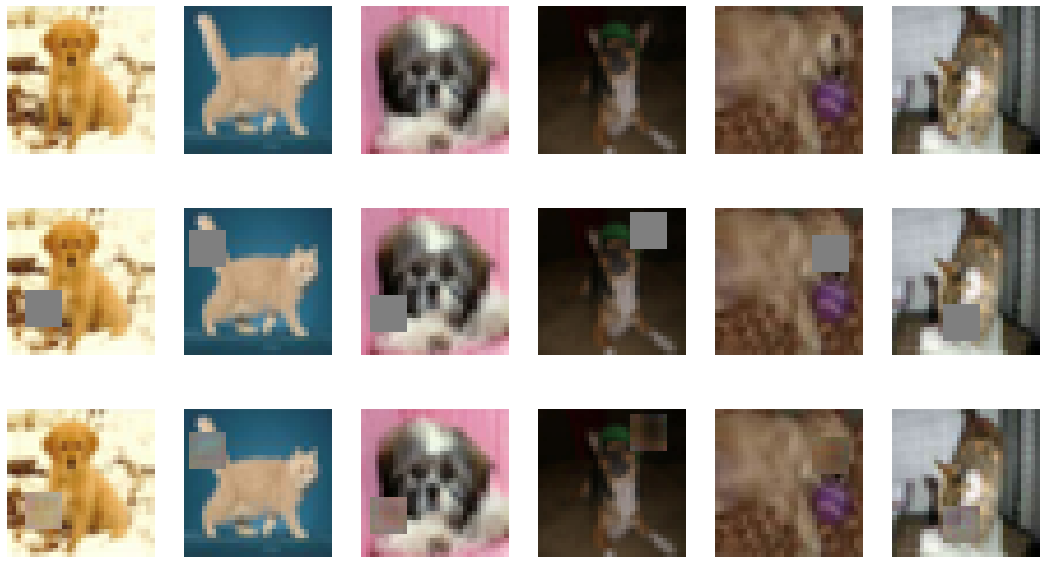

2/2 [==============================] - 0s 11ms/step
676 [D loss: 0.004332, acc: 100.00%] [G loss: 0.177194, mse: 0.175444]
2/2 [==============================] - 0s 11ms/step
677 [D loss: 0.000307, acc: 100.00%] [G loss: 0.185186, mse: 0.183438]
2/2 [==============================] - 0s 10ms/step
678 [D loss: 0.001529, acc: 100.00%] [G loss: 0.196821, mse: 0.195129]
2/2 [==============================] - 0s 11ms/step
679 [D loss: 0.001031, acc: 100.00%] [G loss: 0.195826, mse: 0.193833]
2/2 [==============================] - 0s 10ms/step
680 [D loss: 0.001242, acc: 100.00%] [G loss: 0.196228, mse: 0.194544]
2/2 [==============================] - 0s 11ms/step
681 [D loss: 0.003085, acc: 100.00%] [G loss: 0.207070, mse: 0.204973]
2/2 [==============================] - 0s 11ms/step
682 [D loss: 0.001626, acc: 100.00%] [G loss: 0.196757, mse: 0.194411]
2/2 [==============================] - 0s 10ms/step
683 [D loss: 0.000830, acc: 100.00%] [G loss: 0.183668, mse: 0.181647]
2/2 [===========

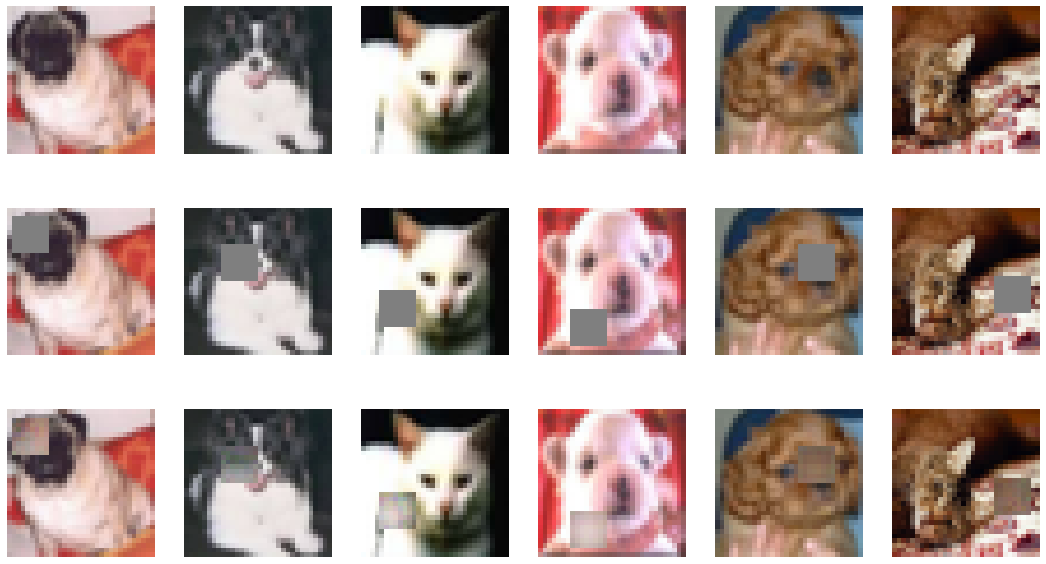

2/2 [==============================] - 0s 11ms/step
701 [D loss: 0.000307, acc: 100.00%] [G loss: 0.199809, mse: 0.199180]
2/2 [==============================] - 0s 10ms/step
702 [D loss: 0.002619, acc: 100.00%] [G loss: 0.169892, mse: 0.168782]
2/2 [==============================] - 0s 10ms/step
703 [D loss: 0.008862, acc: 100.00%] [G loss: 0.213845, mse: 0.213215]
2/2 [==============================] - 0s 11ms/step
704 [D loss: 0.001138, acc: 100.00%] [G loss: 0.175123, mse: 0.173831]
2/2 [==============================] - 0s 10ms/step
705 [D loss: 0.000501, acc: 100.00%] [G loss: 0.210520, mse: 0.209465]
2/2 [==============================] - 0s 10ms/step
706 [D loss: 0.000177, acc: 100.00%] [G loss: 0.192780, mse: 0.191713]
2/2 [==============================] - 0s 12ms/step
707 [D loss: 0.003250, acc: 100.00%] [G loss: 0.179641, mse: 0.178882]
2/2 [==============================] - 0s 11ms/step
708 [D loss: 0.001733, acc: 100.00%] [G loss: 0.202575, mse: 0.201652]
2/2 [===========

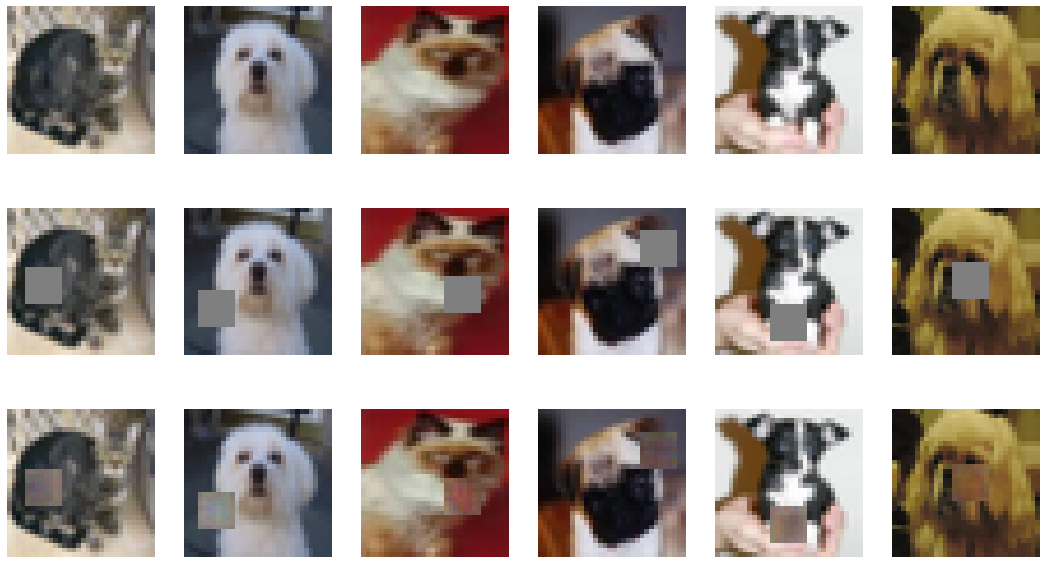

2/2 [==============================] - 0s 11ms/step
726 [D loss: 0.001150, acc: 100.00%] [G loss: 0.178187, mse: 0.177452]
2/2 [==============================] - 0s 14ms/step
727 [D loss: 0.000203, acc: 100.00%] [G loss: 0.169454, mse: 0.168519]
2/2 [==============================] - 0s 12ms/step
728 [D loss: 0.000496, acc: 100.00%] [G loss: 0.201563, mse: 0.200558]
2/2 [==============================] - 0s 10ms/step
729 [D loss: 0.001382, acc: 100.00%] [G loss: 0.193364, mse: 0.192788]
2/2 [==============================] - 0s 10ms/step
730 [D loss: 0.000329, acc: 100.00%] [G loss: 0.177222, mse: 0.176690]
2/2 [==============================] - 0s 11ms/step
731 [D loss: 0.000194, acc: 100.00%] [G loss: 0.177239, mse: 0.176647]
2/2 [==============================] - 0s 11ms/step
732 [D loss: 0.001220, acc: 100.00%] [G loss: 0.175765, mse: 0.175136]
2/2 [==============================] - 0s 12ms/step
733 [D loss: 0.002645, acc: 100.00%] [G loss: 0.174243, mse: 0.173180]
2/2 [===========

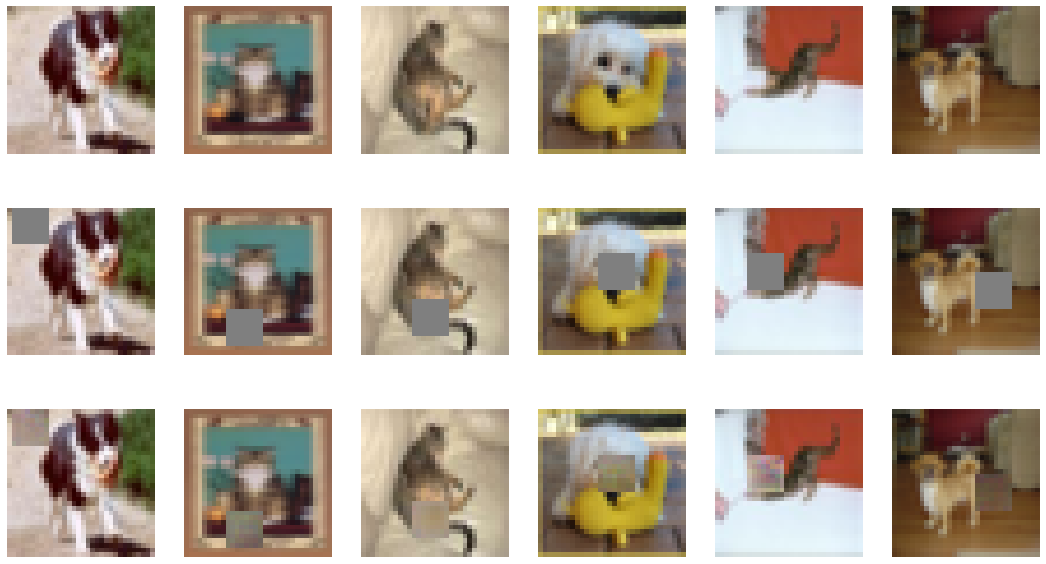

2/2 [==============================] - 0s 12ms/step
751 [D loss: 0.000736, acc: 100.00%] [G loss: 0.167606, mse: 0.167133]
2/2 [==============================] - 0s 18ms/step
752 [D loss: 0.000866, acc: 100.00%] [G loss: 0.190647, mse: 0.190206]
2/2 [==============================] - 0s 11ms/step
753 [D loss: 0.002128, acc: 100.00%] [G loss: 0.201009, mse: 0.200760]
2/2 [==============================] - 0s 13ms/step
754 [D loss: 0.001207, acc: 100.00%] [G loss: 0.177668, mse: 0.177281]
2/2 [==============================] - 0s 11ms/step
755 [D loss: 0.000218, acc: 100.00%] [G loss: 0.175903, mse: 0.175293]
2/2 [==============================] - 0s 10ms/step
756 [D loss: 0.000703, acc: 100.00%] [G loss: 0.202121, mse: 0.201610]
2/2 [==============================] - 0s 10ms/step
757 [D loss: 0.000298, acc: 100.00%] [G loss: 0.182668, mse: 0.181784]
2/2 [==============================] - 0s 11ms/step
758 [D loss: 0.000142, acc: 100.00%] [G loss: 0.194080, mse: 0.193081]
2/2 [===========

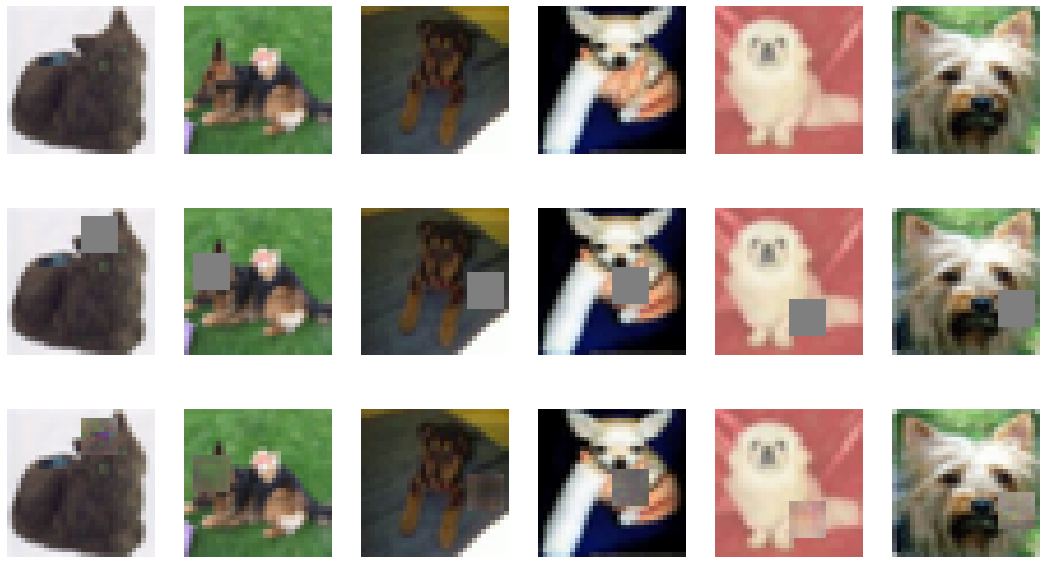

2/2 [==============================] - 0s 11ms/step
776 [D loss: 0.001215, acc: 100.00%] [G loss: 0.149649, mse: 0.148311]
2/2 [==============================] - 0s 11ms/step
777 [D loss: 0.000628, acc: 100.00%] [G loss: 0.199329, mse: 0.198345]
2/2 [==============================] - 0s 10ms/step
778 [D loss: 0.000233, acc: 100.00%] [G loss: 0.169870, mse: 0.168755]
2/2 [==============================] - 0s 11ms/step
779 [D loss: 0.001493, acc: 100.00%] [G loss: 0.191626, mse: 0.189762]
2/2 [==============================] - 0s 11ms/step
780 [D loss: 0.000643, acc: 100.00%] [G loss: 0.181879, mse: 0.179785]
2/2 [==============================] - 0s 12ms/step
781 [D loss: 0.000389, acc: 100.00%] [G loss: 0.190846, mse: 0.189286]
2/2 [==============================] - 0s 17ms/step
782 [D loss: 0.000292, acc: 100.00%] [G loss: 0.203064, mse: 0.201660]
2/2 [==============================] - 0s 13ms/step
783 [D loss: 0.000259, acc: 100.00%] [G loss: 0.213806, mse: 0.212725]
2/2 [===========

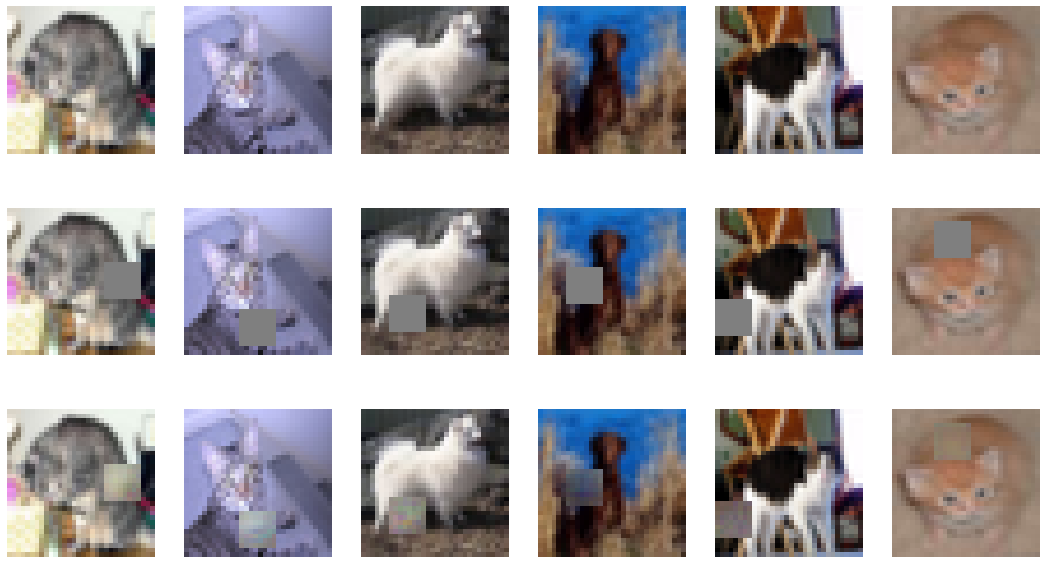

2/2 [==============================] - 0s 13ms/step
801 [D loss: 0.000455, acc: 100.00%] [G loss: 0.195483, mse: 0.195038]
2/2 [==============================] - 0s 11ms/step
802 [D loss: 0.000947, acc: 100.00%] [G loss: 0.179424, mse: 0.179051]
2/2 [==============================] - 0s 12ms/step
803 [D loss: 0.000214, acc: 100.00%] [G loss: 0.195864, mse: 0.194933]
2/2 [==============================] - 0s 13ms/step
804 [D loss: 0.000602, acc: 100.00%] [G loss: 0.203331, mse: 0.202287]
2/2 [==============================] - 0s 12ms/step
805 [D loss: 0.000071, acc: 100.00%] [G loss: 0.170756, mse: 0.169845]
2/2 [==============================] - 0s 10ms/step
806 [D loss: 0.000509, acc: 100.00%] [G loss: 0.176209, mse: 0.175029]
2/2 [==============================] - 0s 11ms/step
807 [D loss: 0.000188, acc: 100.00%] [G loss: 0.172274, mse: 0.171200]
2/2 [==============================] - 0s 11ms/step
808 [D loss: 0.000085, acc: 100.00%] [G loss: 0.199164, mse: 0.198061]
2/2 [===========

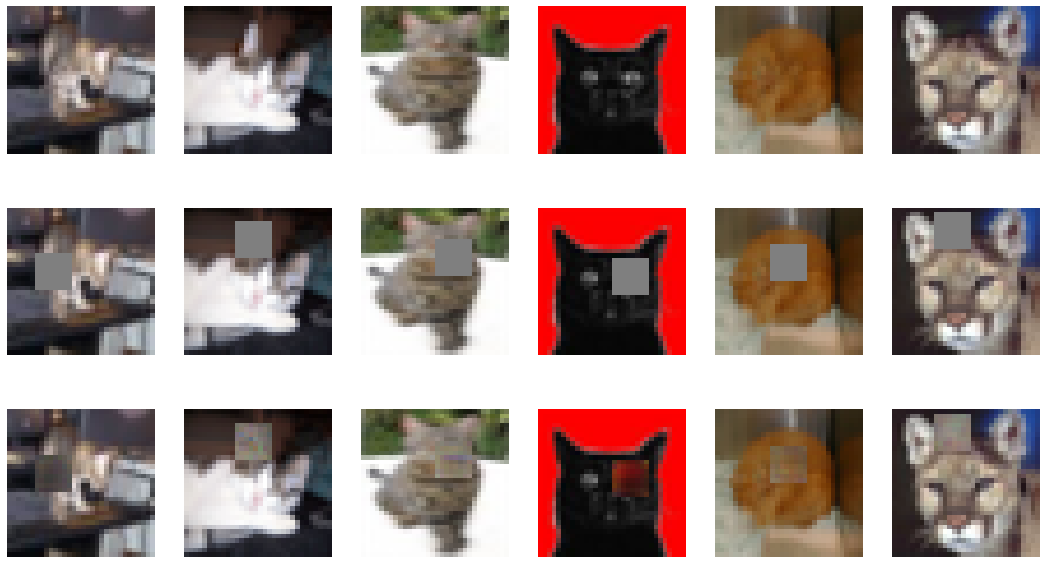

2/2 [==============================] - 0s 13ms/step
826 [D loss: 0.000250, acc: 100.00%] [G loss: 0.174615, mse: 0.173661]
2/2 [==============================] - 0s 10ms/step
827 [D loss: 0.001012, acc: 100.00%] [G loss: 0.177325, mse: 0.176604]
2/2 [==============================] - 0s 11ms/step
828 [D loss: 0.000627, acc: 100.00%] [G loss: 0.195675, mse: 0.194520]
2/2 [==============================] - 0s 12ms/step
829 [D loss: 0.000438, acc: 100.00%] [G loss: 0.193579, mse: 0.192723]
2/2 [==============================] - 0s 14ms/step
830 [D loss: 0.000342, acc: 100.00%] [G loss: 0.172939, mse: 0.171991]
2/2 [==============================] - 0s 12ms/step
831 [D loss: 0.000218, acc: 100.00%] [G loss: 0.152067, mse: 0.150808]
2/2 [==============================] - 0s 21ms/step
832 [D loss: 0.000292, acc: 100.00%] [G loss: 0.185245, mse: 0.184102]
2/2 [==============================] - 0s 10ms/step
833 [D loss: 0.001990, acc: 100.00%] [G loss: 0.182615, mse: 0.181567]
2/2 [===========

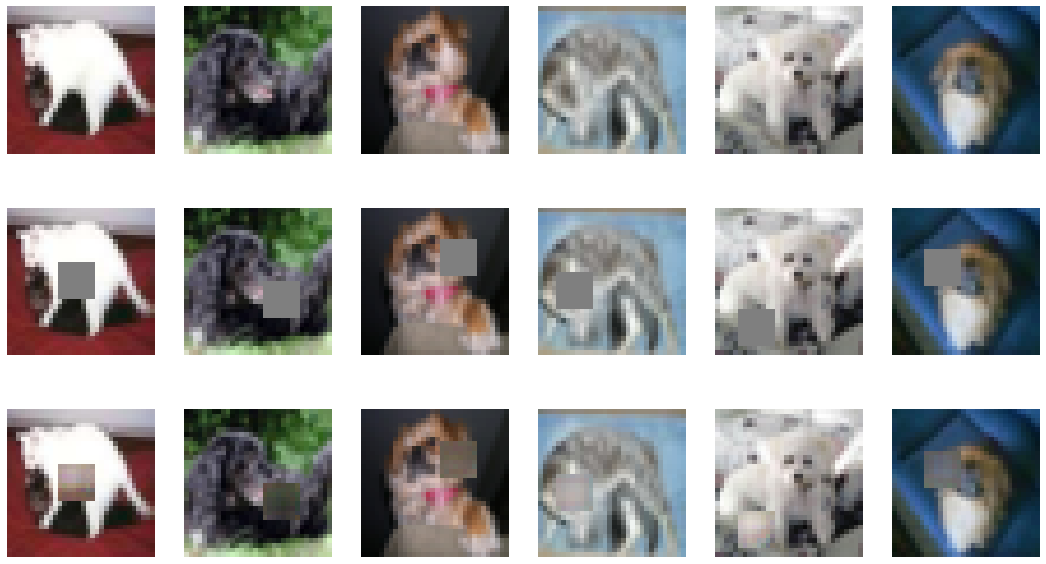

2/2 [==============================] - 0s 12ms/step
851 [D loss: 0.001042, acc: 100.00%] [G loss: 0.164756, mse: 0.164415]
2/2 [==============================] - 0s 10ms/step
852 [D loss: 0.005590, acc: 100.00%] [G loss: 0.215380, mse: 0.215073]
2/2 [==============================] - 0s 11ms/step
853 [D loss: 0.001044, acc: 100.00%] [G loss: 0.184146, mse: 0.183290]
2/2 [==============================] - 0s 10ms/step
854 [D loss: 0.006858, acc: 100.00%] [G loss: 0.202011, mse: 0.201364]
2/2 [==============================] - 0s 11ms/step
855 [D loss: 0.000665, acc: 100.00%] [G loss: 0.176903, mse: 0.176044]
2/2 [==============================] - 0s 11ms/step
856 [D loss: 0.001611, acc: 100.00%] [G loss: 0.191230, mse: 0.190482]
2/2 [==============================] - 0s 13ms/step
857 [D loss: 0.001881, acc: 100.00%] [G loss: 0.209644, mse: 0.209075]
2/2 [==============================] - 0s 12ms/step
858 [D loss: 0.000383, acc: 100.00%] [G loss: 0.198916, mse: 0.198198]
2/2 [===========

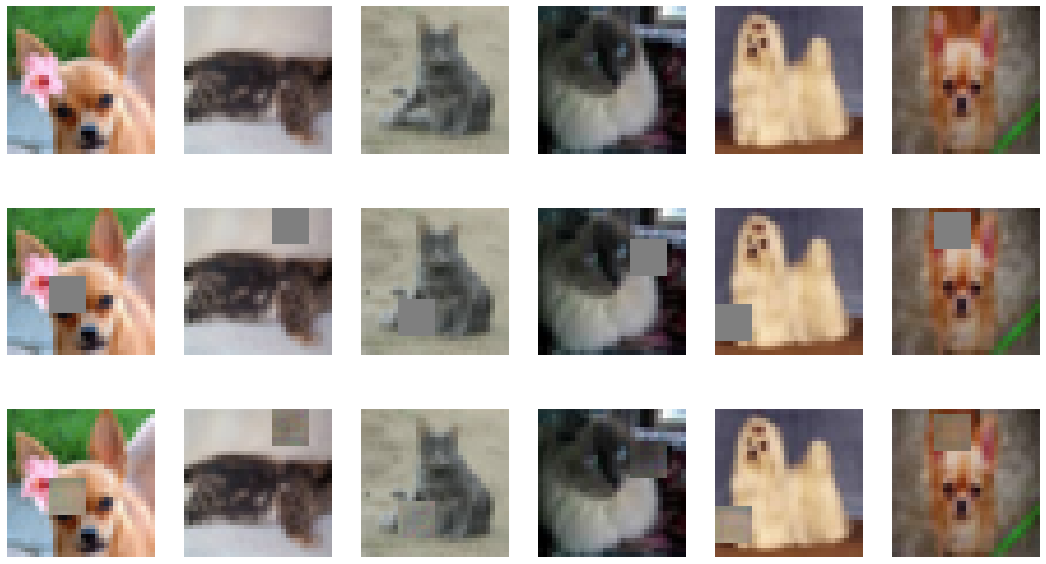

2/2 [==============================] - 0s 12ms/step
876 [D loss: 0.000817, acc: 100.00%] [G loss: 0.177378, mse: 0.176099]
2/2 [==============================] - 0s 10ms/step
877 [D loss: 0.006965, acc: 100.00%] [G loss: 0.194539, mse: 0.193018]
2/2 [==============================] - 0s 10ms/step
878 [D loss: 0.000709, acc: 100.00%] [G loss: 0.201314, mse: 0.200053]
2/2 [==============================] - 0s 12ms/step
879 [D loss: 0.000787, acc: 100.00%] [G loss: 0.169011, mse: 0.167781]
2/2 [==============================] - 0s 10ms/step
880 [D loss: 0.001714, acc: 100.00%] [G loss: 0.188756, mse: 0.187890]
2/2 [==============================] - 0s 11ms/step
881 [D loss: 0.001656, acc: 100.00%] [G loss: 0.177564, mse: 0.176401]
2/2 [==============================] - 0s 13ms/step
882 [D loss: 0.000503, acc: 100.00%] [G loss: 0.174685, mse: 0.173905]
2/2 [==============================] - 0s 10ms/step
883 [D loss: 0.001080, acc: 100.00%] [G loss: 0.206446, mse: 0.205498]
2/2 [===========

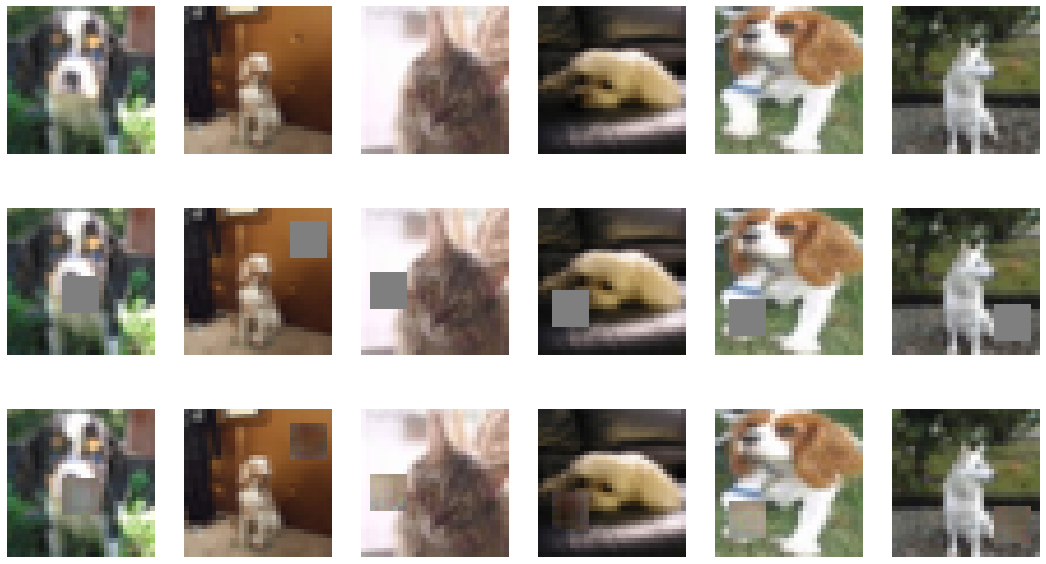

2/2 [==============================] - 0s 12ms/step
901 [D loss: 0.001142, acc: 100.00%] [G loss: 0.221159, mse: 0.219695]
2/2 [==============================] - 0s 11ms/step
902 [D loss: 0.000923, acc: 100.00%] [G loss: 0.157387, mse: 0.155460]
2/2 [==============================] - 0s 13ms/step
903 [D loss: 0.000929, acc: 100.00%] [G loss: 0.186126, mse: 0.184885]
2/2 [==============================] - 0s 11ms/step
904 [D loss: 0.000705, acc: 100.00%] [G loss: 0.175983, mse: 0.174491]
2/2 [==============================] - 0s 12ms/step
905 [D loss: 0.000467, acc: 100.00%] [G loss: 0.157295, mse: 0.155664]
2/2 [==============================] - 0s 12ms/step
906 [D loss: 0.000324, acc: 100.00%] [G loss: 0.179778, mse: 0.178191]
2/2 [==============================] - 0s 13ms/step
907 [D loss: 0.003111, acc: 100.00%] [G loss: 0.176290, mse: 0.174125]
2/2 [==============================] - 0s 11ms/step
908 [D loss: 0.000699, acc: 100.00%] [G loss: 0.173310, mse: 0.171702]
2/2 [===========

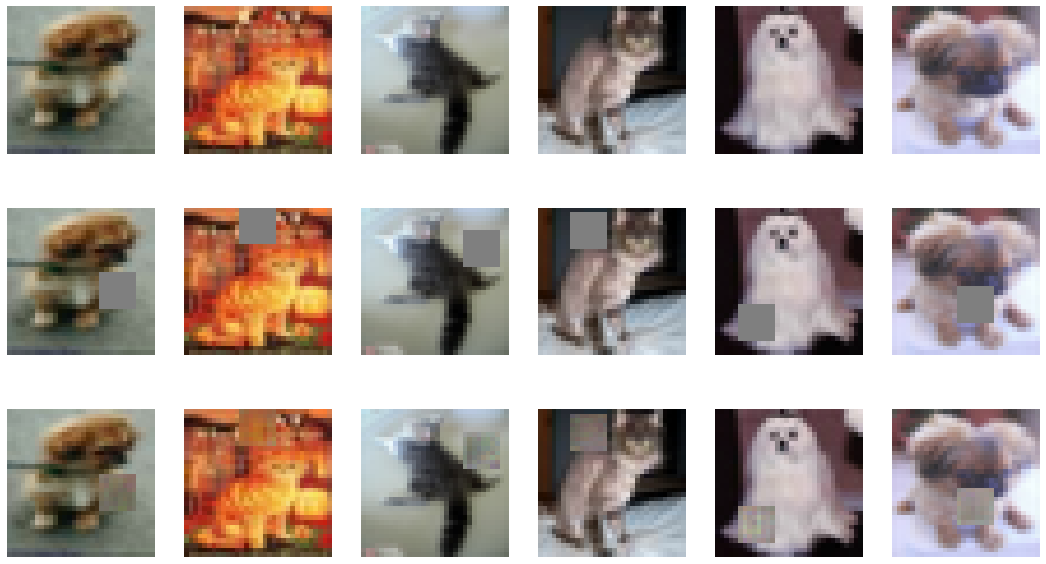

2/2 [==============================] - 0s 10ms/step
926 [D loss: 0.001236, acc: 100.00%] [G loss: 0.182402, mse: 0.181349]
2/2 [==============================] - 0s 13ms/step
927 [D loss: 0.000438, acc: 100.00%] [G loss: 0.192350, mse: 0.191634]
2/2 [==============================] - 0s 10ms/step
928 [D loss: 0.002919, acc: 100.00%] [G loss: 0.165299, mse: 0.164194]
2/2 [==============================] - 0s 12ms/step
929 [D loss: 0.000731, acc: 100.00%] [G loss: 0.163762, mse: 0.162391]
2/2 [==============================] - 0s 11ms/step
930 [D loss: 0.000410, acc: 100.00%] [G loss: 0.173041, mse: 0.171814]
2/2 [==============================] - 0s 10ms/step
931 [D loss: 0.000200, acc: 100.00%] [G loss: 0.157418, mse: 0.156171]
2/2 [==============================] - 0s 12ms/step
932 [D loss: 0.000543, acc: 100.00%] [G loss: 0.180233, mse: 0.179112]
2/2 [==============================] - 0s 14ms/step
933 [D loss: 0.000279, acc: 100.00%] [G loss: 0.188534, mse: 0.187356]
2/2 [===========

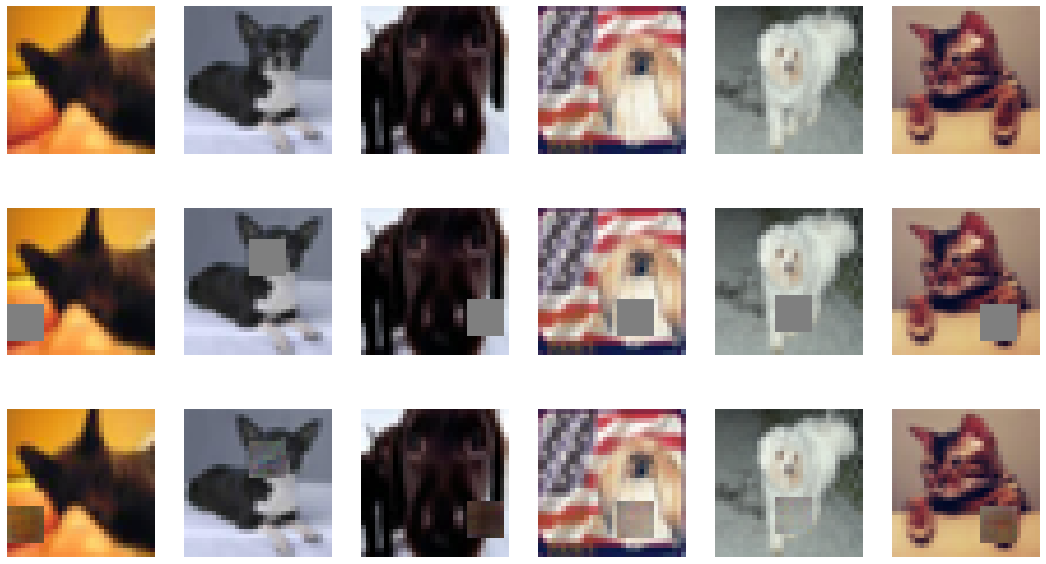

2/2 [==============================] - 0s 11ms/step
951 [D loss: 0.000430, acc: 100.00%] [G loss: 0.176960, mse: 0.176202]
2/2 [==============================] - 0s 11ms/step
952 [D loss: 0.000485, acc: 100.00%] [G loss: 0.166700, mse: 0.165533]
2/2 [==============================] - 0s 11ms/step
953 [D loss: 0.000233, acc: 100.00%] [G loss: 0.154077, mse: 0.153067]
2/2 [==============================] - 0s 11ms/step
954 [D loss: 0.002010, acc: 100.00%] [G loss: 0.206886, mse: 0.206209]
2/2 [==============================] - 0s 12ms/step
955 [D loss: 0.000487, acc: 100.00%] [G loss: 0.175922, mse: 0.175146]
2/2 [==============================] - 0s 10ms/step
956 [D loss: 0.000365, acc: 100.00%] [G loss: 0.178332, mse: 0.177348]
2/2 [==============================] - 0s 10ms/step
957 [D loss: 0.000946, acc: 100.00%] [G loss: 0.202793, mse: 0.202127]
2/2 [==============================] - 0s 12ms/step
958 [D loss: 0.000306, acc: 100.00%] [G loss: 0.212648, mse: 0.211954]
2/2 [===========

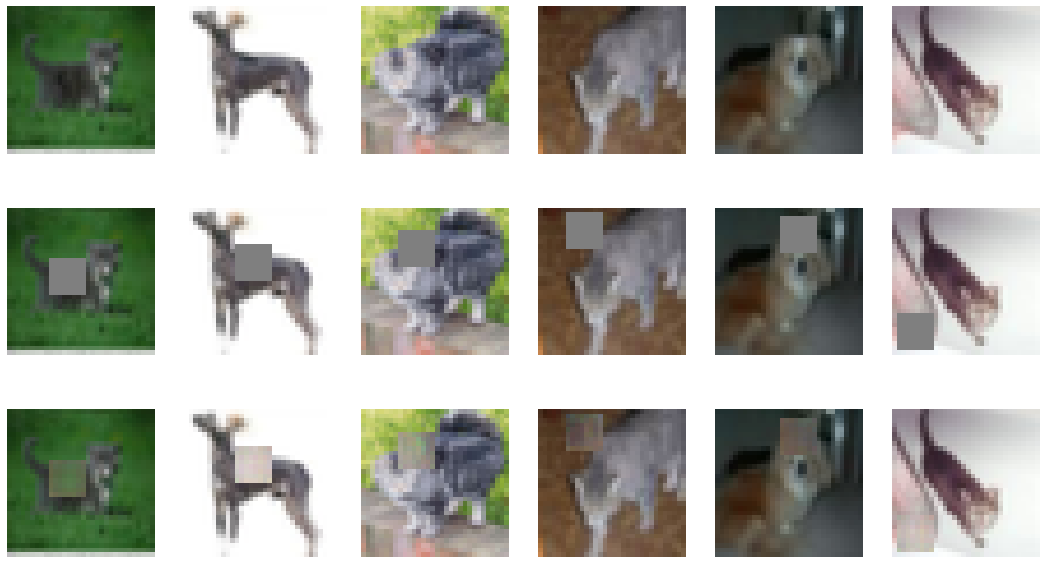

2/2 [==============================] - 0s 10ms/step
976 [D loss: 0.000919, acc: 100.00%] [G loss: 0.144037, mse: 0.142816]
2/2 [==============================] - 0s 11ms/step
977 [D loss: 0.000912, acc: 100.00%] [G loss: 0.158113, mse: 0.157256]
2/2 [==============================] - 0s 11ms/step
978 [D loss: 0.000930, acc: 100.00%] [G loss: 0.170131, mse: 0.169359]
2/2 [==============================] - 0s 11ms/step
979 [D loss: 0.000963, acc: 100.00%] [G loss: 0.170231, mse: 0.169443]
2/2 [==============================] - 0s 9ms/step
980 [D loss: 0.000907, acc: 100.00%] [G loss: 0.158988, mse: 0.157755]
2/2 [==============================] - 0s 10ms/step
981 [D loss: 0.000779, acc: 100.00%] [G loss: 0.175695, mse: 0.174591]
2/2 [==============================] - 0s 10ms/step
982 [D loss: 0.000586, acc: 100.00%] [G loss: 0.224835, mse: 0.223981]
2/2 [==============================] - 0s 10ms/step
983 [D loss: 0.000295, acc: 100.00%] [G loss: 0.173127, mse: 0.171913]
2/2 [============

In [2]:

context_encoder = ContextEncoder()
context_encoder.train(epochs=1000, batch_size=64, sample_interval=25)